In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pickle
import io

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from sklearn import cluster, metrics, model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.special import rel_entr
from scipy.spatial import distance_matrix
from plotly.subplots import make_subplots
from PIL import Image

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

# Probabilistic PCA from a GitHub fork (Ludvig Hult) 
# ! pip install git+https://github.com/el-hult/pyppca
from pyppca import ppca

In [2]:
bzcat = pd.read_csv('data/BZCAT_all_features.csv')  # Catalog, all features 
model_df = bzcat.copy()  # model dataframe
model_df.head(3)

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Class,Rad_opt_sp_index,alpha_1.1-2.3,alpha_2.3-4.8,alpha_4.8-7.7,alpha_4.8-11.2,...,IR_opt,IR_UV,IR_X,IR_gamma,opt_UV,opt_X,opt_gamma,UV_X,UV_gamma,X_gamma
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,BZQ,0.707,NaN,0.056,-0.763,NaN,...,NaN,-0.434905,0.966619,NaN,NaN,NaN,NaN,1.401524,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,BZQ,0.661,NaN,-0.281,-0.599,-0.788,...,-0.40052,-0.189982,NaN,NaN,0.210538,NaN,NaN,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,BZQ,0.917,-0.117,0.029,0.276,-0.427,...,0.18340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 1. Cleansing

Missing values heatmap

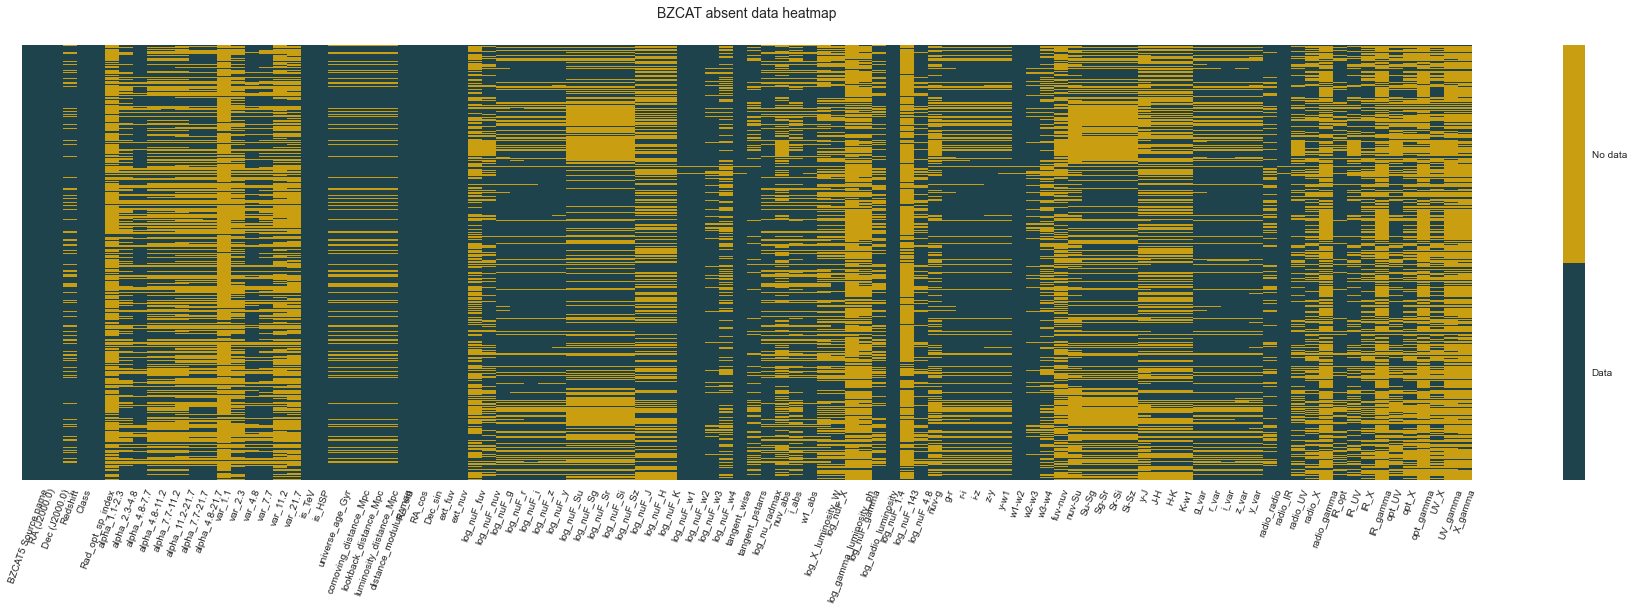

In [3]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCAT absent data heatmap', y=1.05, fontsize = 14);

The fraction of missing values in some columns

In [4]:
model_df.iloc[:,100:120].isnull().mean()

opt_gamma    0.774502
UV_X         0.528503
UV_gamma     0.797248
X_gamma      0.779837
dtype: float64

Dropping columns with many missing values

In [5]:
cols_to_drop = model_df.isnull().mean() > 0.4  
cols_to_drop = cols_to_drop[cols_to_drop].index

model_df.drop(columns=cols_to_drop, inplace=True)

1. Deleting distance-related features with analytical dependence (directly calculated from the redshift):
    * 'Redshift', 'universe_age_Gyr', 'comoving_distance_Mpc', 'lookback_distance_Mpc', 'luminosity_distance_Mpc', 'distance_modulus_mag'
2. The object names and coordinates are not necessary for the modeling.
3. The class (categorical variable) gives a trivial result in clustering: to be deleted from the model dataframe.
4. Deleting colors: the equal and more robust information are in the 'tangent_wise', 'tangent_panstarrs' features
5. Deleting optical absolute magnitudes: they were only for illustration puprposes, no K-corrections, strong correlation with distances and other features
6. Deleting UV extinctions: they are not needed for modeling
7. Deleting features that generate new selection effects in the clustering algorithm: for blazars variabilities are dependent on the number of observations, wich has not a physical meaning.

The model dataframe, includes comoving distance, as we anyway use flux ratios (hardnesses) and spectrum slopes claculated for the observer's frame of reference. Comoving distance could also help to take into account the "natural" observable selection effects, which cannot be removed from the sample.

In [6]:
model_df = model_df.drop(columns=[
    'Redshift', 'universe_age_Gyr', 'lookback_distance_Mpc',
    'luminosity_distance_Mpc', 'distance_modulus_mag', 'BZCAT5 Source name', 'Class',
    'RA (J2000.0)', 'Dec (J2000.0)', 'RA_sin', 'RA_cos', 'Dec_sin',
    'g-r', 'r-i', 'i-z', 'z-y', 'y-w1', 'w1-w2', 'w2-w3', 'w3-w4',
    'i_abs', 
    'w1_abs', 
    'ext_fuv', 'ext_nuv',
    'var_4.8', 'var_7.7', 
    'g_var', 'r_var', 'i_var', 'z_var', 'y_var',
    'is_TeV', 'is_HSP'
    ]).copy()

Missing values heatmap after the dropping

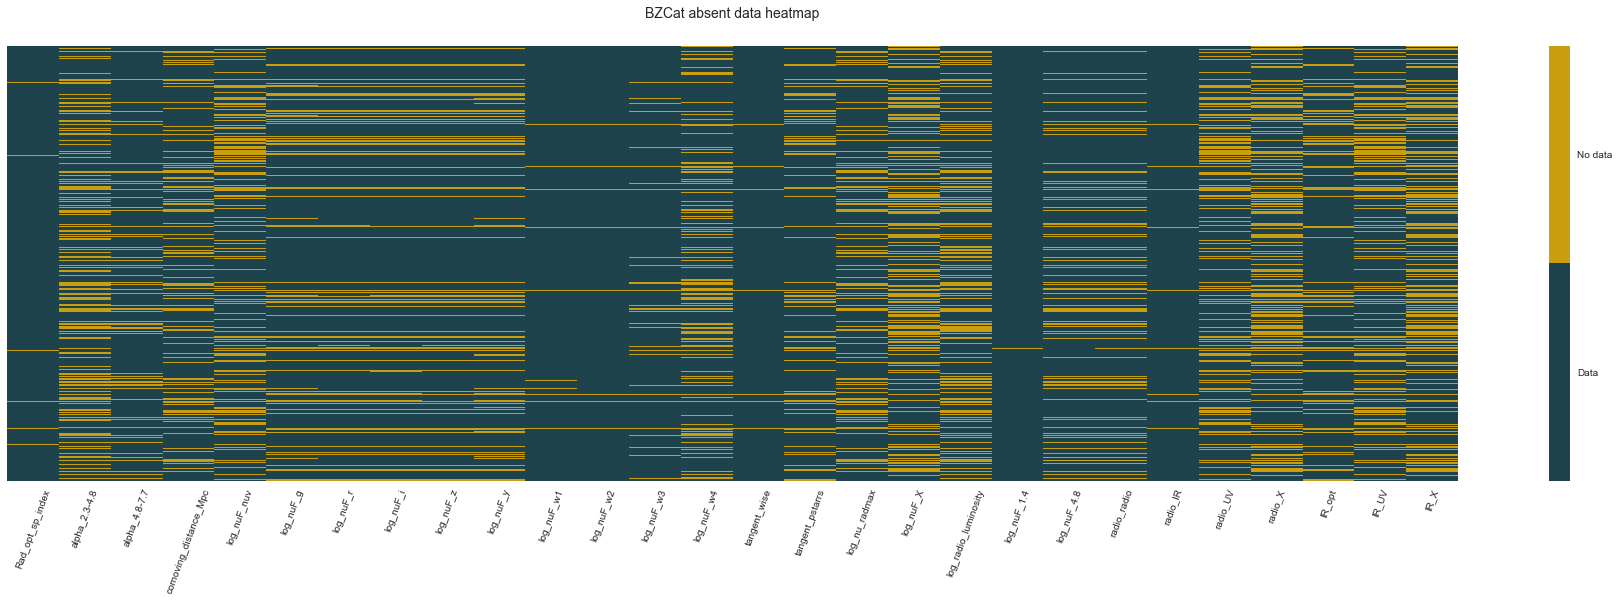

In [7]:
colors = ['#1e434c', '#c99e10'] 
fig = plt.figure(figsize=(32.5, 8))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'])

plt.xticks(rotation=70)
ax.set_title('BZCat absent data heatmap', y=1.05, fontsize = 14);

Many features here are naturally correlated and have the same nature (like fluxes), while simulataneously having dispersed values; we will combine them further via PCA into single variables (e.g., fluxes -> flux). Nevetherless, there are other correlated features of different kinds. Let's look.

In [8]:
def get_correlated(corr_matrix, thres=0.7):
    """Getting correlated pairs from a correlation matrix 
       with correlation coefficients higher than the threshold

    Args:
        corr_matrix (pandas DataFrame): correlation matrix (e.g., from df.corr())
        thres (float, optional): threshold. Defaults to 0.7 (i.e., coeff > 0.7 or coeff < -0.7).

    Returns:
        pandas Series: correlated pairs and correlation coefficients
    """
    
    correlated_pairs = {}
    
    for col in corr_matrix.columns:
        positive_filter = corr_matrix[col] >= thres
        negative_filter = corr_matrix[col] <= -thres
        match_series = corr_matrix[col][positive_filter | negative_filter]
        for match in match_series.index:
            if match != col and match + ' -- ' + col not in correlated_pairs.keys():
                correlated_pairs.update({col + ' -- ' + match: match_series[match]})
   
    return pd.Series(correlated_pairs).sort_values()

In [9]:
hardnesses = [
    'Rad_opt_sp_index',
    'radio_radio',
    'radio_IR',
    'radio_UV',
    'radio_X',
    'IR_opt',
    'IR_UV',
    'IR_X'    
]

cols_to_look = [
    'tangent_wise', 'comoving_distance_Mpc',
    'tangent_pstarrs', 'log_nu_radmax', 'log_radio_luminosity', 
    ]
cols_to_look.extend(hardnesses)

get_correlated(model_df[cols_to_look].corr())

radio_X -- IR_X                                  0.703958
log_radio_luminosity -- Rad_opt_sp_index         0.706351
Rad_opt_sp_index -- radio_X                      0.713060
log_radio_luminosity -- radio_IR                 0.736221
Rad_opt_sp_index -- radio_UV                     0.741984
radio_UV -- radio_X                              0.769788
radio_IR -- radio_X                              0.777085
Rad_opt_sp_index -- radio_IR                     0.794226
radio_IR -- radio_UV                             0.815335
comoving_distance_Mpc -- log_radio_luminosity    0.846103
dtype: float64

In [10]:
model_df.columns

Index(['Rad_opt_sp_index', 'alpha_2.3-4.8', 'alpha_4.8-7.7',
       'comoving_distance_Mpc', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r',
       'log_nuF_i', 'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2',
       'log_nuF_w3', 'log_nuF_w4', 'tangent_wise', 'tangent_pstarrs',
       'log_nu_radmax', 'log_nuF_X', 'log_radio_luminosity', 'log_nuF_1.4',
       'log_nuF_4.8', 'radio_radio', 'radio_IR', 'radio_UV', 'radio_X',
       'IR_opt', 'IR_UV', 'IR_X'],
      dtype='object')

In [11]:
shortwl_fluxes = [
    'log_nuF_X', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 
    'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2', 
    'log_nuF_w3', 'log_nuF_w4']                 
radio_fluxes = ['log_nuF_1.4', 'log_nuF_4.8']

In [12]:
from scipy.stats import kendalltau

kendalltau(model_df['log_nuF_g'], model_df['alpha_2.3-4.8'], nan_policy='omit')

KendalltauResult(correlation=-0.02783534042242326, pvalue=0.06963344054457628)

The following cells are commented: eventually, I didn't take variabilities to the model dataset, as it creates an "artificial" cluster with large variabilities, but this is only because of the great number of measurements.

Converting optical variabilities to the logarithmic scale

In [13]:
#model_df['g_var'] = np.log(model_df['g_var'])
#model_df['r_var'] = np.log(model_df['r_var'])
#model_df['i_var'] = np.log(model_df['i_var'])
#model_df['z_var'] = np.log(model_df['z_var'])
#model_df['y_var'] = np.log(model_df['y_var'])

There is a small artificial peak near $\rm{ var}_{7.7}=1$ in the distribution of the radio variability at 7.7 GHz. Let's try to clean it.

In [14]:
#sns.histplot(data=model_df, x='var_7.7', bins=30);

In [15]:
# Original scatterplot
#fig = px.scatter(model_df, x='var_7.7', y='var_4.8', width=650, height=400)
#fig.show()

In [16]:
# Masked scatterplot
#mask = (model_df['var_4.8']<0.8) & (model_df['var_7.7']>0.95)
#fig = px.scatter(model_df[~mask], x='var_7.7', y='var_4.8', width=650, height=400)
#fig.show()

#print(f'The number of points to be converted to NaNs: '
#      f'{model_df[mask].shape[0]}')

In [17]:
#model_df.mask(mask, np.NaN, inplace=True)

#sns.histplot(data=model_df, x='var_7.7', bins=30);

Saving the file to analyze via the Sweetviz report

In [18]:
model_df.to_csv('data/bzcat_for_profiling.csv')

**Outliers**

I'm cleaning the outliers manually by reviewing the Sweetvis report distributions. The removed objects are stored as anomalies in a separate dataframe. They don't paticipate in the clustering, but are going to be processed later using the KNN classification. Some strings are commented because these characteristics were not eventually included in the clustering dataset.

In [19]:
mask = model_df['Rad_opt_sp_index'] < -0.15
anomalies = model_df[mask].copy()
anomalies['Anomaly'] = 'Rad_opt_sp_index'
model_df = model_df[~mask]

# Further, alphas don't take part in clustering, thus no outliers filtration!!!

#mask = model_df['alpha_2.3-4.8'] < -2
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_2.3-4.8', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['alpha_4.8-7.7'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'alpha_4.8-7.7', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['var_4.8'] < -0.2
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'var_4.8', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['var_7.7'] < -0.3
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'var_7.7', inplace=True)
#model_df = model_df[~mask]

mask = (model_df['log_nuF_g'] < -14)  
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_g', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w1'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w1', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w2'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w2', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w3'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w3', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_w4'] > -9.8
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_w4', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_wise'] < -1.3) | (model_df['tangent_wise'] > 3.2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_wise', inplace=True)
model_df = model_df[~mask]

mask = (model_df['tangent_pstarrs'] < -4) | (model_df['tangent_pstarrs'] > 4)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'tangent_pstarrs', inplace=True)
model_df = model_df[~mask]

mask = (model_df['log_nu_radmax'] < 11) | (model_df['log_nu_radmax'] > 18)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nu_radmax', inplace=True)
model_df = model_df[~mask]

#mask = model_df['i_abs']  > -18
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'i_abs', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['w1_abs']  > -22
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'w1_abs', inplace=True)
#model_df = model_df[~mask]

mask = model_df['log_nuF_X'] > -10
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_X', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_1.4'] > -11.4
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_1.4', inplace=True)
model_df = model_df[~mask]

mask = model_df['log_nuF_4.8'] > -11
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_nuF_4.8', inplace=True)
model_df = model_df[~mask]

#mask = model_df['g_var'] < -6
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'g_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['r_var'] < -6
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'r_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['i_var'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'i_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['z_var'] < -4.5
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'z_var', inplace=True)
#model_df = model_df[~mask]

#mask = model_df['y_var'] < -4
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'y_var', inplace=True)
#model_df = model_df[~mask]

#mask = (model_df['log_radio_luminosity'] < 52)
mask = (model_df['log_radio_luminosity'] < 22.5)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'log_radio_luminosity', inplace=True)
model_df = model_df[~mask]

#mask = (model_df['radio_radio']<-1.5)
#anomalies = pd.concat([anomalies, model_df[mask]])
#anomalies['Anomaly'].replace(np.NaN, 'radio_radio', inplace=True)
#model_df = model_df[~mask]

mask = (model_df['radio_IR']>0.5)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'radio_IR', inplace=True)
model_df = model_df[~mask]

mask = (model_df['radio_X']>0.7)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'radio_X', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_opt']>1.7) 
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_opt', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_UV']<-1.25) | (model_df['IR_UV']>2)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_UV', inplace=True)
model_df = model_df[~mask]

mask = (model_df['IR_X']>2.15)
anomalies = pd.concat([anomalies, model_df[mask]])
anomalies['Anomaly'].replace(np.NaN, 'IR_X', inplace=True)
model_df = model_df[~mask]

print(f'Number of outliers: {anomalies.shape[0]}')
anomalies.head(3)

Number of outliers: 34


,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,...,log_nuF_1.4,log_nuF_4.8,radio_radio,radio_IR,radio_UV,radio_X,IR_opt,IR_UV,IR_X,Anomaly
916,-0.260,NaN,0.632,88.096983,-11.627384,-9.898098,-9.825438,-9.866171,-9.917871,-10.633408,...,-13.771087,-13.226396,-0.54469,-2.758275,-2.143703,-1.584000,-1.14664,0.614573,1.174275,Rad_opt_sp_index
2777,-0.363,NaN,-0.149,118.733490,-11.572598,-9.977698,-9.943838,-9.995771,-10.055871,-10.862368,...,-14.097997,-13.791827,-0.30617,-2.991186,-2.525399,-2.965465,-1.11104,0.465787,0.025721,Rad_opt_sp_index
3042,-0.269,NaN,NaN,248.861612,-12.627066,-11.927978,-11.666238,-11.595371,-11.551871,-11.597888,...,-14.899629,NaN,NaN,-3.033218,-2.272563,-3.194096,-0.27104,0.760655,-0.160877,Rad_opt_sp_index


---

## 2. Preprocessing

In this section we deal with the first dimensionality reduction where some deeply connected physical characteristics are combined to corresponding single variables

The features of the same nature to combine to single variables (e.g., radio_vars -> radio_var). Most are correlated with each other.

In [20]:
#radio_vars = ['var_4.8', 'var_7.7']                         
#opt_vars = ['g_var', 'r_var', 'i_var', 'z_var', 'y_var']  
shortwl_fluxes = [
    'log_nuF_X', 'log_nuF_nuv', 'log_nuF_g', 'log_nuF_r', 'log_nuF_i', 
    'log_nuF_z', 'log_nuF_y', 'log_nuF_w1', 'log_nuF_w2', 
    'log_nuF_w3', 'log_nuF_w4']                 
radio_fluxes = ['log_nuF_1.4', 'log_nuF_4.8']

First scaling. Several scalings and several PCA transformations will be made during the project, this is due to the approach of gradual dimensionality reduction, also we use probabilistic PCA for guessing the missing values and this nonparametric method makes its own adjustments to the data processing.

In [21]:
scaler1 = StandardScaler()
model_df = pd.DataFrame(scaler1.fit_transform(model_df),
                            columns=model_df.columns, index=model_df.index)

# Save scaling model to the drive
with open('data/model/scaler1.pkl', 'wb') as f:
    pickle.dump(scaler1, f)

model_df.describe()

,Rad_opt_sp_index,alpha_2.3-4.8,alpha_4.8-7.7,comoving_distance_Mpc,log_nuF_nuv,log_nuF_g,log_nuF_r,log_nuF_i,log_nuF_z,log_nuF_y,...,log_radio_luminosity,log_nuF_1.4,log_nuF_4.8,radio_radio,radio_IR,radio_UV,radio_X,IR_opt,IR_UV,IR_X
count,3.506000e+03,2.288000e+03,2.935000e+03,2.810000e+03,2.490000e+03,2.843000e+03,2.872000e+03,2.888000e+03,2.880000e+03,2.847000e+03,...,2.367000e+03,3.516000e+03,2.874000e+03,2.863000e+03,3.465000e+03,2.489000e+03,2.221000e+03,2.860000e+03,2.471000e+03,2.198000e+03
mean,3.425035e-16,1.397484e-17,-8.473252e-18,1.062021e-16,-2.108800e-15,2.339318e-15,-2.302089e-15,-3.631444e-15,2.077351e-15,-2.294851e-15,...,1.227765e-15,1.754127e-15,-1.473499e-15,2.159176e-16,1.640503e-16,1.056251e-16,1.887529e-16,6.397369e-17,2.192589e-17,-4.040848e-17
std,1.000143e+00,1.000219e+00,1.000170e+00,1.000178e+00,1.000201e+00,1.000176e+00,1.000174e+00,1.000173e+00,1.000174e+00,1.000176e+00,...,1.000211e+00,1.000142e+00,1.000174e+00,1.000175e+00,1.000144e+00,1.000201e+00,1.000225e+00,1.000175e+00,1.000202e+00,1.000228e+00
min,-3.847948e+00,-6.996567e+00,-5.565039e+00,-1.782250e+00,-2.957057e+00,-2.500860e+00,-3.352164e+00,-2.812891e+00,-2.778770e+00,-2.782494e+00,...,-3.632845e+00,-3.252695e+00,-3.298030e+00,-6.624289e+00,-2.861547e+00,-2.947237e+00,-2.949559e+00,-3.836743e+00,-2.619112e+00,-3.274511e+00
25%,-7.019257e-01,-5.711317e-01,-5.032728e-01,-8.586377e-01,-7.018231e-01,-6.914300e-01,-6.723183e-01,-6.610374e-01,-6.870462e-01,-7.381127e-01,...,-5.053935e-01,-6.473147e-01,-6.443670e-01,-5.644106e-01,-8.159072e-01,-7.508586e-01,-7.656059e-01,-6.882169e-01,-7.658582e-01,-6.094013e-01
50%,1.122291e-01,-1.663547e-02,4.611160e-02,-8.743950e-04,-4.408150e-02,-1.980083e-02,-3.662594e-02,-5.440387e-02,-7.021202e-02,-1.267496e-01,...,2.012875e-01,1.390528e-01,4.030755e-02,7.694335e-02,5.206806e-03,-1.287435e-02,2.724014e-01,-1.410095e-01,-1.414925e-01,9.369645e-02
75%,7.571570e-01,5.849089e-01,5.765966e-01,7.883169e-01,6.759984e-01,6.398322e-01,6.310255e-01,6.212523e-01,6.201800e-01,6.288591e-01,...,7.013895e-01,7.172538e-01,6.692743e-01,6.697393e-01,7.933799e-01,7.412098e-01,7.881027e-01,5.882953e-01,6.889147e-01,6.626610e-01
max,3.086359e+00,4.570561e+00,4.167472e+00,3.039434e+00,4.628585e+00,4.847588e+00,4.966255e+00,5.069601e+00,5.149942e+00,5.419851e+00,...,2.635108e+00,3.200242e+00,3.380971e+00,3.078343e+00,2.712380e+00,3.291422e+00,2.178780e+00,4.678618e+00,3.895244e+00,3.194473e+00


**Probabilistic PCA**

Two steps:
1. Guessing the missing values with probabilistic PCA (Tipping and Bishop 1999, “Mixtures of probabilistic principal component analysers”, Neural Computation 11(2),
pp. 443–482. MIT Press.). I used Ludvig Hult's code: https://github.com/el-hult/pyppca. The algorithm is actually from Porta et al., 2005, Autonomous Robots, 18, 59 ([https://inria.hal.science/inria-00321476](https://inria.hal.science/inria-00321476)). 
2. Converting the features to a single principal component using the standard sklearn PCA.

In [22]:
def ppca_transform(df, cols, model_name):
    np.random.seed(42)
    
    # The PPCA algorithm produces data of the initial dimension
    # (filled in missing values)
    Y = np.array(df[cols])
    C, ss, M, X, Ye = ppca(Y, 2, False)  # Here 2d latent space (the minimum)
    
    # Reducing dimensionality to 1
    pipeline_pca1 = Pipeline([
        ('scaler', StandardScaler()),  # scaling after ppca
        ('pca', (PCA(n_components=1, random_state=42)))])  # sklearn pca
    out_col = pipeline_pca1.fit_transform(Ye)
    
    # The combined value is NaN if all initial values are NaNs 
    # (no filling with mean values)
    out_col[df[cols].isnull().all(axis=1)] = np.NaN
    
    # Saving sklearn PCA models
    filename = 'data/model/pca1_' + model_name + '.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(pipeline_pca1, f)    
        
    return out_col

In [23]:
#model_df['radio_var'] = ppca_transform(model_df, radio_vars, 'radio_vars')
#model_df['opt_var'] = ppca_transform(model_df, opt_vars, 'opt_vars')
model_df['shortwl_flux'] = ppca_transform(model_df, shortwl_fluxes, 'shortwl_fluxes')
model_df['radio_flux'] = ppca_transform(model_df, radio_fluxes, 'radio_fluxes')
#cols_drop = radio_vars + opt_vars + shortwl_fluxes + radio_fluxes
cols_drop = shortwl_fluxes + radio_fluxes
model_df.drop(columns=cols_drop, inplace=True)

scaler2 = StandardScaler()
model_df = pd.DataFrame(scaler2.fit_transform(model_df),
                        columns=model_df.columns, index=model_df.index)   
with open('data/model/scaler2.pkl', 'wb') as f:
        pickle.dump(scaler2, f)

#new_cols = ['radio_var', 'opt_var', 'shortwl_flux', 'radio_flux']
new_cols = ['shortwl_flux', 'radio_flux']
bzcat[new_cols] = model_df[new_cols]

---

## 3. Clustering

Some functions

In [24]:
def plot_metrics(X):
    """Plot some metrics depending on the number of clusters"""
    inertia = []
    silhouette = []
    calinski_harabasz = []
    davis_bouldin = []
    
    for n_cl in range(2, 11):
        kmeans = cluster.KMeans(n_clusters=n_cl, random_state=42)
        kmeans.fit(X)
    
        inertia.append(kmeans.inertia_)
        silhouette.append(metrics.silhouette_score(
            X, kmeans.labels_))
        calinski_harabasz.append(metrics.calinski_harabasz_score(
            X, kmeans.labels_))
        davis_bouldin.append(metrics.davies_bouldin_score(
            X, kmeans.labels_))
        
    fig, ax = plt.subplots(1, 4, figsize=(24,5))
    
    ax[0].plot(range(2, 11), inertia, 's-', label='inertia')
    ax[1].plot(range(2, 11), silhouette, 's-', label='silhouette')
    ax[2].plot(range(2, 11), calinski_harabasz, 's-', label='calinski-harabasz')
    ax[3].plot(range(2, 11), davis_bouldin, 's-', label='davis-bouldin')
    ax[0].legend(prop={'size': 20})
    ax[1].legend(prop={'size': 20})
    ax[2].legend(prop={'size': 20})
    ax[3].legend(prop={'size': 20});
    
    
def make_kmeans_clusters(model_df, dataset_df, n_clusters, perplexity):
    """Make KMeans clusters and calculate some metrics"""
    kmeans = cluster.KMeans(n_clusters=n_clusters, random_state=42)
    dataset_df['cluster_kmeans'] = kmeans.fit_predict(model_df)
    tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', 
                         learning_rate='auto', random_state=42)
    df_tsne = pd.DataFrame(tsne.fit_transform(model_df))
    df_tsne['c'] = kmeans.labels_
    sns.scatterplot(x=df_tsne[0], y=df_tsne[1], hue=df_tsne['c'], 
        palette='bright')
    plt.title('2D t-SNE representation')
    print('Silhouette: {:.3f}'.format(
        metrics.silhouette_score(model_df, kmeans.labels_)))
    print('Davis-Bouldin: {:.3f}'.format(
        metrics.davies_bouldin_score(model_df, kmeans.labels_)))
    print('Calinski-Harabatz: {:.3f}'.format(
        metrics.calinski_harabasz_score(model_df, kmeans.labels_)))
    print(f'Inertia: {kmeans.inertia_:.3f}')
    centroid_dist = pd.DataFrame(
        distance_matrix(kmeans.cluster_centers_, kmeans.cluster_centers_),
        index=range(n_clusters), columns=range(n_clusters))
    print(centroid_dist)
    
    
def yb_elbow(model_df):
    """Yellowbrick elbow visualizer"""
    vis_distortion = KElbowVisualizer(
         cluster.KMeans(), metrics='distortion', timings=False)
    vis_distortion.fit(model_df)
    vis_distortion.show();


def plot_distr(dataset_df, cols, file=None):
    "Feature distributions for different clusters"
    plt.rcParams['axes.labelsize'] = 18
    sns.set_style({'axes.grid' : False})
    
    nrows = int(np.ceil(len(cols) / 4))
    fig, axes = plt.subplots(nrows, 4, figsize=(25, 3.25*nrows))
    i = 0
    for col, ax in  zip(cols, axes.flatten()):
        sns.boxplot(
            data=dataset_df, x=col, y='cluster_kmeans', 
            hue='cluster_kmeans', palette='tab10',
            orient='h', ax=ax).set(ylabel='Cluster')
        ax.get_legend().remove()
    plt.tight_layout()
    if file is not None:
        plt.savefig('figs/' + file + '.eps', format='eps', bbox_inches='tight')  
        plt.savefig('figs/' + file + '.png', format='png', bbox_inches='tight')      
    plt.rcParams['axes.labelsize'] = 10
    return fig, axes

    
def kl_div(nonans_df, filled_df, bins=10):
    """Kullback-Leibler divergence (sum for each column)"""
    kldiv = 0
    for col in nonans_df:
        hist_range = (nonans_df[col].min(), nonans_df[col].max())
        q, _ = np.histogram(nonans_df[col], bins=bins, range=hist_range)
        q = q / np.sum(q)
        p, _ = np.histogram(filled_df[col], bins=bins, range=hist_range)
        p = p / np.sum(p)
        kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')
    
    
def kl_div_clusters(nonans_df, filled_df, bins=5):
    """Kullback-Leibler divergence (sum for each column and each cluster)"""
    kldiv = 0
    n_clusters = nonans_df['cluster_kmeans'].nunique()
    cols = list(nonans_df.columns)
    cols.remove('cluster_kmeans')
    for col in cols:
        for cluster in range(n_clusters):
            distr_nonan = nonans_df[nonans_df['cluster_kmeans'] == cluster][col]
            distr_filled = filled_df[filled_df['cluster_kmeans'] == cluster][col]
            hist_range = (distr_nonan.min(), distr_nonan.max())
            q, _ = np.histogram(distr_nonan, bins=bins, range=hist_range)
            q = q / np.sum(q)
            p, _ = np.histogram(distr_filled, bins=bins, range=hist_range)
            p = p / np.sum(p)
            kldiv += np.sum(rel_entr(p, q))
    print(f'Kullback-Leibler divergence: {kldiv}')

Final feature selection. I drop the alpha spectral indices and radio-to-radio hardness: the experiments have shown that they stay pretty much the same for different clusters

In [25]:
model_df.drop(columns=['alpha_2.3-4.8', 'alpha_4.8-7.7', 'radio_radio'], inplace=True)

The final model dataframe

In [26]:
model_df

,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,log_radio_luminosity,radio_IR,radio_UV,radio_X,IR_opt,IR_UV,IR_X,shortwl_flux,radio_flux
0,0.677207,0.438604,-1.010169,NaN,-0.191739,0.701391,0.904349,0.395439,1.645611,NaN,-0.938291,1.344796,-0.506213,0.816780
1,0.432028,1.181837,-0.856297,1.039815,-0.240228,0.981401,0.927821,0.716692,NaN,-0.901169,-0.410320,NaN,-0.125732,0.452671
2,1.796504,1.859429,-0.432728,-1.175476,-0.618499,0.917773,1.503319,NaN,NaN,0.773317,NaN,NaN,-1.927985,0.042801
3,-0.143610,NaN,-0.036369,0.114112,NaN,NaN,-0.611520,-0.110721,0.383774,0.123735,0.503633,1.081848,1.039360,-0.045176
4,0.671877,-0.785830,0.726539,-0.645222,0.714779,-1.165919,0.524230,0.568944,NaN,-0.302172,-0.049216,NaN,-0.852345,-0.925236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,0.613248,0.177949,-0.284122,1.437148,0.080754,0.599117,0.727097,0.216671,0.954558,-0.030088,-0.979651,0.448156,0.307493,1.115992
3557,0.837107,0.349843,-0.814972,0.098931,-0.565929,0.335538,0.872725,1.355329,0.635586,0.915438,0.795718,-0.227888,-0.711291,0.527000
3558,-1.470776,-1.404631,0.756090,NaN,4.495719,NaN,-1.067009,-1.200421,-2.239400,NaN,-0.709361,-2.572255,1.700574,-0.309829
3559,0.879747,1.642325,-1.312959,1.134030,-0.232530,0.830423,1.705896,NaN,0.624974,-1.350821,NaN,-1.205204,-0.579469,0.858459


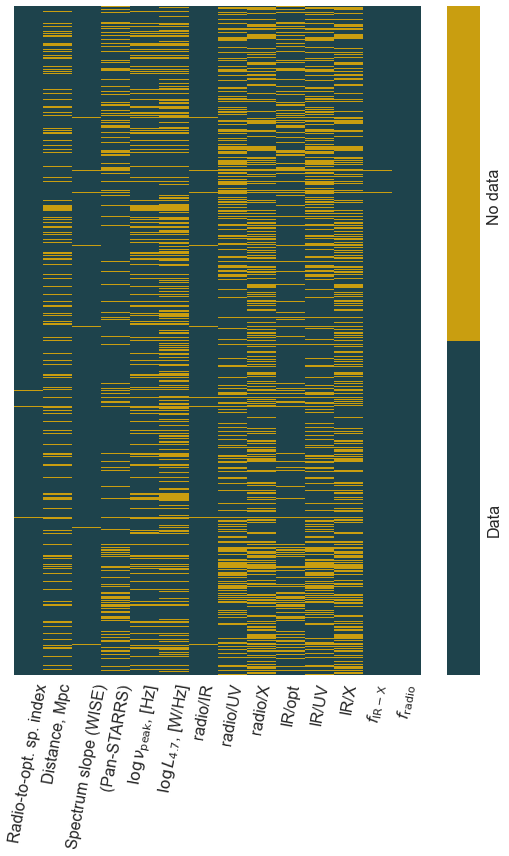

In [28]:
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'

colors = ['#1e434c', '#c99e10'] 
#colors = ['#A96946', '#ECCDB1'] 
fig = plt.figure(figsize=(7.5, 12))
ax = sns.heatmap(
    model_df.isnull(),  
    cmap=sns.color_palette(colors),
    yticklabels=False
)

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([0.25, 0.75])
colorbar.set_ticklabels(['Data', 'No data'], fontsize=16, rotation=90)

labels=[
    'Radio-to-opt. sp. index',
    'Distance, Mpc',
    'Spectrum slope (WISE)',
    '(Pan-STARRS)',
    r'$\log \nu_{\rm peak}$, [Hz]',
    r'$\log L_{4.7}$, [W/Hz]',
    'radio/IR',
    'radio/UV',
    'radio/X',
    'IR/opt',
    'IR/UV',
    'IR/X',
    r'$f_{\rm IR-X}$',
    r'$f_{\rm radio}$'
]
ax.set_xticklabels(labels)

plt.xticks(rotation=80, fontsize=16)
#ax.set_title('Model dataset', y=1.05, fontsize=16)
plt.tight_layout()

plt.savefig('figs/model_dataset.png', format='png', bbox_inches='tight')

### 3.1. PCA + KMeans model with all missing values dropped

In [29]:
model_pca_dropna = model_df.copy()
model_pca_dropna.dropna(inplace=True)
bzcat_pca_dropna = bzcat.iloc[model_pca_dropna.index,:].copy()

# Rescaling after NaNs dropping
scaler = StandardScaler()
model_pca_dropna = pd.DataFrame(scaler.fit_transform(model_pca_dropna),
                        columns=model_pca_dropna.columns, index=model_pca_dropna.index)

model_pca_dropna.shape

(858, 14)

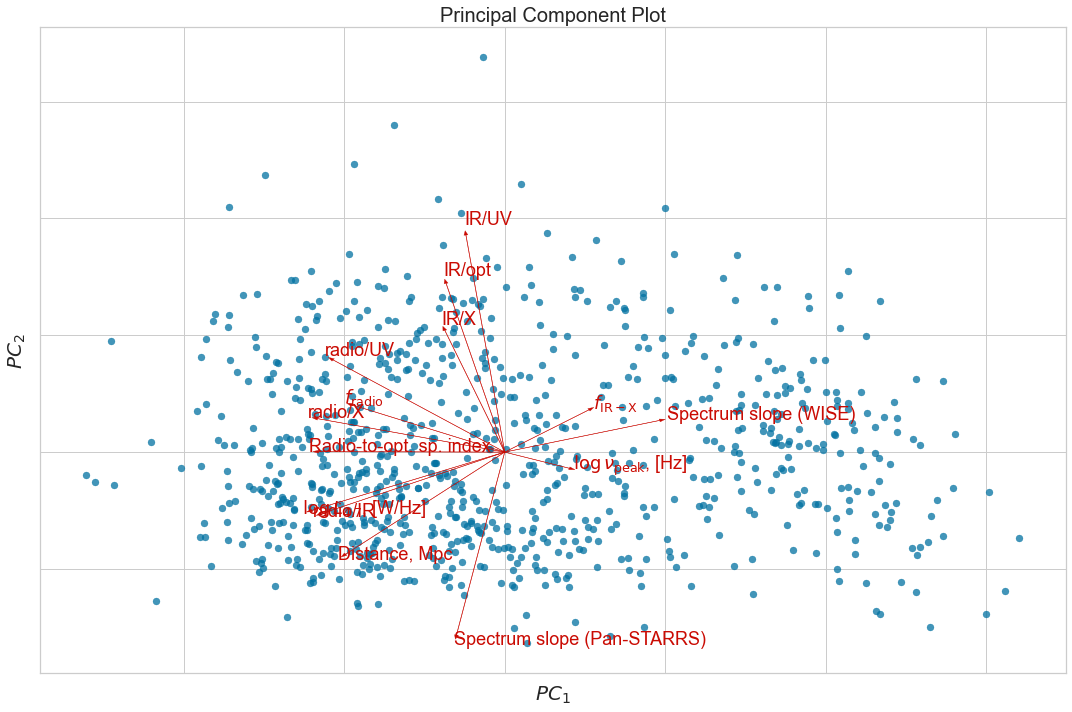

In [30]:
# Yellowbricks visualization
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 20

tmp_tab = model_pca_dropna.copy()
tmp_tab.rename(
    columns={
        'Rad_opt_sp_index': 'Radio-to-opt. sp. index',
        'comoving_distance_Mpc': 'Distance, Mpc',
        'tangent_wise': 'Spectrum slope (WISE)',
        'tangent_pstarrs': 'Spectrum slope (Pan-STARRS)',
        'log_nu_radmax': r'$\log \nu_{\rm peak}$, [Hz]',
        'log_radio_luminosity': r'$\log L_{4.7}$, [W/Hz]',
        'radio_IR': 'radio/IR',
        'radio_UV': 'radio/UV',
        'radio_X': 'radio/X',
        'IR_opt': 'IR/opt',
        'IR_UV': 'IR/UV',
        'IR_X': 'IR/X',
        'shortwl_flux': r'$f_{\rm IR-X}$',
        'radio_flux': r'$f_{\rm radio}$'
        },
    inplace=True
)

from yellowbrick.features import RadViz
visualizer = RadViz(size=(1080, 720))

from yellowbrick.features import PCA as PCA_yb

visualizer = PCA_yb(scale=True, proj_features=True)
visualizer.fit_transform(tmp_tab)

for label in visualizer.ax.texts:
    label.set_size(18)
visualizer.show(outpath='figs/PCA_biplot.png');

In [31]:
# Contribution of the features to the two first PCs

scores = np.linalg.norm(visualizer.pca_components_, axis=0)
scores

array([0.36176445, 0.40283883, 0.31169319, 0.47190552, 0.13204202,
       0.40283129, 0.38859827, 0.4069277 , 0.37333959, 0.44169632,
       0.55414506, 0.32910965, 0.19555704, 0.32028493])

In [32]:
np.linalg.norm(visualizer.pca_components_, axis=0) / np.sum(scores)

array([0.07103541, 0.0791007 , 0.06120351, 0.09266251, 0.02592753,
       0.07909922, 0.07630445, 0.07990359, 0.07330829, 0.08673069,
       0.10881092, 0.06462338, 0.03839923, 0.06289057])

In [33]:
visualizer.features_

array(['Radio-to-opt. sp. index', 'Distance, Mpc',
       'Spectrum slope (WISE)', 'Spectrum slope (Pan-STARRS)',
       '$\\log \\nu_{\\rm peak}$, [Hz]', '$\\log L_{4.7}$, [W/Hz]',
       'radio/IR', 'radio/UV', 'radio/X', 'IR/opt', 'IR/UV', 'IR/X',
       '$f_{\\rm IR-X}$', '$f_{\\rm radio}$'], dtype=object)

PCA dimensionality reduction with 90% dispersion explained

In [34]:
# pca
pca = PCA(n_components=0.9, random_state=42)
X = pca.fit_transform(model_pca_dropna)
print(f'The number of principal components: {pca.n_components_}')

The number of principal components: 6


Looking at the metrics (the optimal number of clusters)

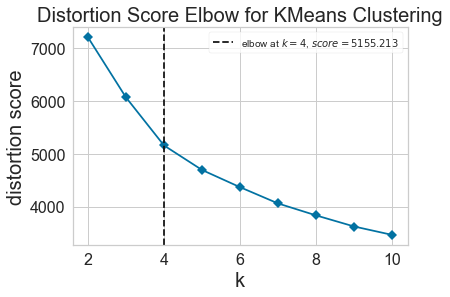

In [35]:
yb_elbow(X)

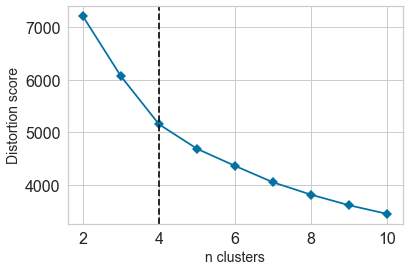

In [36]:
# Figure for the paper

vis_distortion = KElbowVisualizer(
    cluster.KMeans(), timings=False)
vis_distortion.fit(X)
vis_distortion.ax.set_xlabel('n clusters', fontsize=14)
vis_distortion.ax.set_ylabel('Distortion score', fontsize=14)

plt.savefig('./figs/elbow.eps', format='eps')

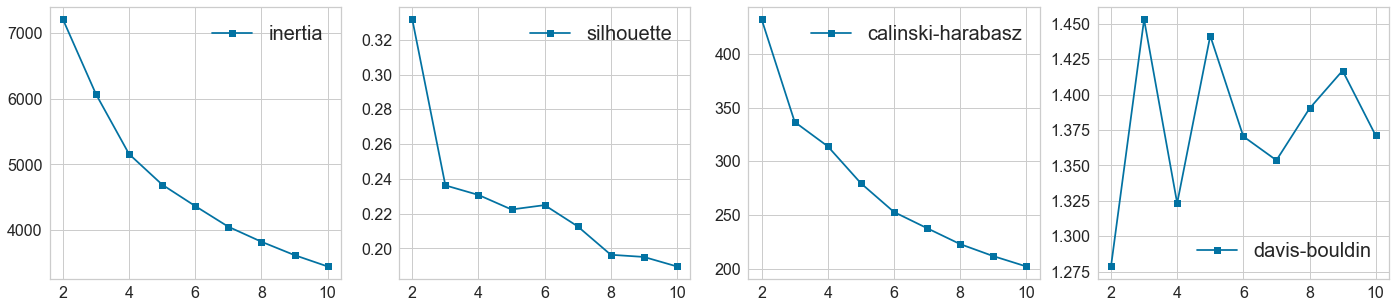

In [37]:
plot_metrics(X)

Making five clusters using K-Means. Several clustering algorithms have been tested, this is the best in our case. We also evaluate clustering metrics, distances between the centroids (in 8d space, the table), and plot the 2d and 3d representations of the 8d space (t-SNE is used: t-distributed stochastic neighbor embedding).

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Silhouette: 0.222
Davis-Bouldin: 1.442
Calinski-Harabatz: 279.521
Inertia: 4691.096
          0         1         2         3         4
0  0.000000  3.498257  2.964887  3.475213  4.481831
1  3.498257  0.000000  3.070607  4.415584  5.849194
2  2.964887  3.070607  0.000000  5.686318  6.398011
3  3.475213  4.415584  5.686318  0.000000  3.368297
4  4.481831  5.849194  6.398011  3.368297  0.000000


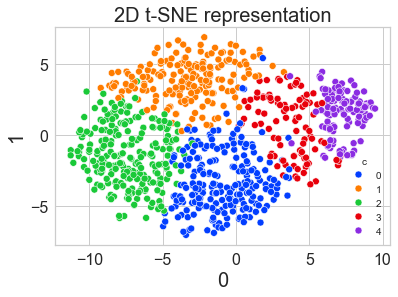

In [38]:
make_kmeans_clusters(X, bzcat_pca_dropna, 5, 150)

Reassigning cluster numbers (based on the number of BL Lac objects in a cluster)  

In [39]:
bzcat_pca_dropna['cluster_kmeans'].replace({4:0, 3:1, 1:2, 0:3, 2:4}, 
                                           inplace=True)
#bzcat_pca_dropna['cluster_kmeans'].replace({2:0, 0:1, 3:2, 4:3, 1:4}, 
#                                           inplace=True)
#bzcat_pca_dropna['cluster_kmeans'].replace({2:0, 3:1, 0:2, 1:3, 4:4}, 
#                                           inplace=True)

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


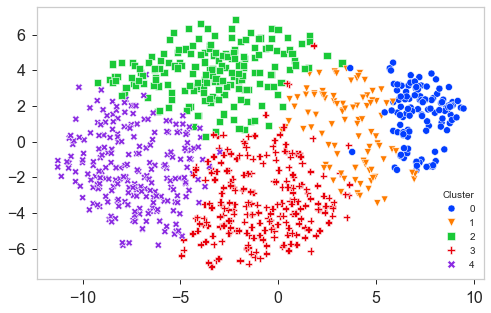

In [40]:
# Figure for the paper

tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'], s=50)
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
plt.legend(title='Cluster', loc='lower right')
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/tsne_nonans.eps', format='eps')

TeV blazars

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


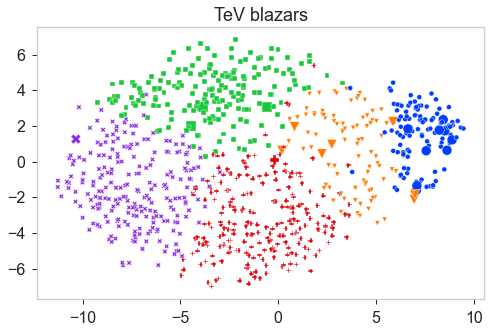

In [41]:
# TeV blazars

tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
df_tsne['size'] = bzcat_pca_dropna.reset_index()['is_TeV'].astype(int) * 6
df_tsne.loc[~bzcat_pca_dropna.reset_index()['is_TeV'], 'size'] = 1

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright',
                     size= 'size',
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'])
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
#plt.legend(title='Cluster', loc='lower right')
#from matplotlib.lines import Line2D
#custom = [Line2D([], [], marker='.', color='b', linestyle='None'),
#          Line2D([], [], marker='.', color='r', linestyle='None')]
#plt.legend(custom, ['Yes', 'No'], loc='lower right')
ax.get_legend().remove()
ax.set_title('TeV blazars', fontsize=18)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/TeV.png', format='png')
plt.savefig('./figs/TeV.eps', format='eps')

HSP blazars

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


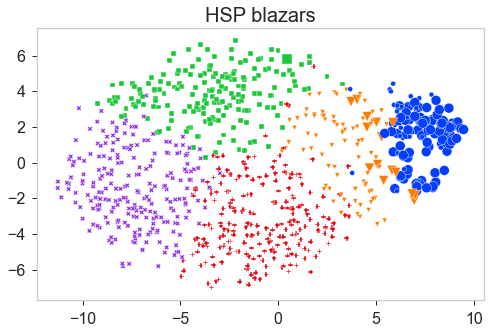

In [42]:
# HSP blazars
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16


tsne = TSNE(n_components=2, perplexity=150, init='pca',
            learning_rate='auto', random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
df_tsne['size'] = bzcat_pca_dropna.reset_index()['is_HSP'].astype(int) * 6
df_tsne.loc[~bzcat_pca_dropna.reset_index()['is_HSP'], 'size'] = 1

plt.figure(figsize=(8, 5))
ax = sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright',
                     size= 'size', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'])
ax.tick_params(direction='out', length=5, width=1)
plt.grid(False)
ax.get_legend().remove()
ax.set_title('HSP blazars', fontsize=20)
plt.xlabel('', fontsize=14)
plt.ylabel('', fontsize=14)
plt.savefig('./figs/HSP.png', format='png')
plt.savefig('./figs/HSP.eps', format='eps')

Comparison with the SOM clustering (external data)

In [43]:
som = pd.read_csv('data/SOM_clusters.csv')

df_tsne = pd.concat([df_tsne, som], axis=1)
df_tsne['cluster_SOM'].replace({3:0, 4:1, 2:2, 1:3, 0:4}, inplace=True)
df_tsne.rename(columns={'cluster_SOM': 'Cluster_SOM'}, inplace=True)

metrics.rand_score(df_tsne['Cluster'], df_tsne['Cluster_SOM'])

0.949971848454929

PCA+k-means and SOM in t-SNE coordinates

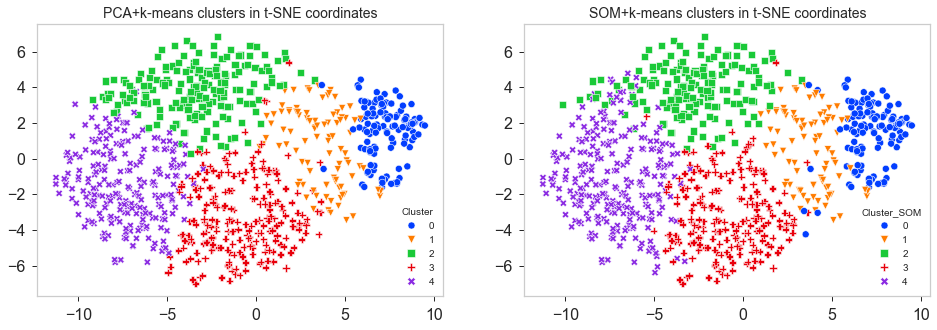

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster', palette='bright', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'], s=50, ax=ax[0])
sns.scatterplot(data=df_tsne, x=0, y=1, hue='Cluster_SOM', palette='bright', 
                style='Cluster_SOM', markers=['o', 'v', 's', 'P', 'X'], s=50, ax=ax[1])
ax[0].set_title('PCA+k-means clusters in t-SNE coordinates', fontsize=14)
ax[1].set_title('SOM+k-means clusters in t-SNE coordinates', fontsize=14)

for axi in ax.flatten():
    axi.tick_params(direction='out', length=5, width=1)
    axi.grid(False)
    axi.set_xlabel('', fontsize=14)
    axi.set_ylabel('', fontsize=14)
#plt.savefig('./figs/comparing_in_tsne.png', format='png')
plt.savefig('./figs/comparing_in_tsne.eps', format='eps')

PCA+k-means and SOM in the SOM plane

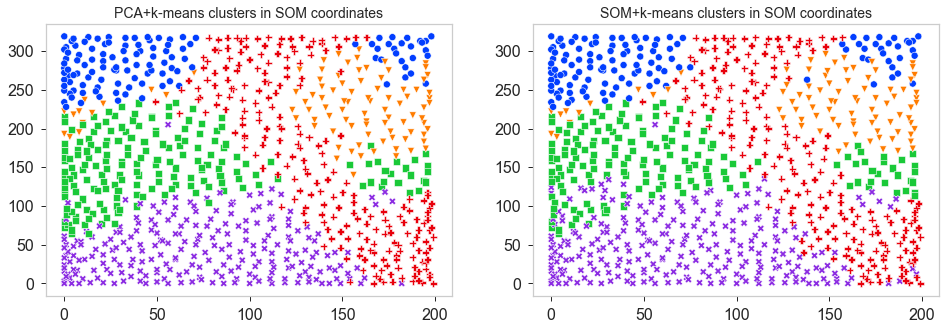

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(data=df_tsne, x='i_SOM', y='j_SOM', hue='Cluster', palette='bright', 
                style='Cluster', markers=['o', 'v', 's', 'P', 'X'], s=50, ax=ax[0])
sns.scatterplot(data=df_tsne, x='i_SOM', y='j_SOM', hue='Cluster_SOM', palette='bright', 
                style='Cluster_SOM', markers=['o', 'v', 's', 'P', 'X'], s=50, ax=ax[1])
ax[0].set_title('PCA+k-means clusters in SOM coordinates', fontsize=14)
ax[1].set_title('SOM+k-means clusters in SOM coordinates', fontsize=14)

for axi in ax.flatten():
    axi.tick_params(direction='out', length=5, width=1)
    axi.grid(False)
    axi.set_xlabel('', fontsize=14)
    axi.set_ylabel('', fontsize=14)
    axi.get_legend().set_visible(False)
#plt.savefig('./figs/comparing_in_som.png', format='png')
plt.savefig('./figs/comparing_in_som.eps', format='eps')

In 3D t-SNE coordinates

In [46]:
tsne = TSNE(n_components=3, perplexity=150, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
df_tsne['Cluster'] = df_tsne['Cluster'].astype('str')
fig = px.scatter_3d(df_tsne, x=0, y=1, z=2,
              color='Cluster', width=650, height=400,
              color_discrete_sequence=['#636EFA', '#FFA15A', '#00CC96',  '#EF553B',  '#AB63FA'],
              category_orders={'Cluster': ['0', '1', '2', '3', '4']})
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.write_html('figs/clusters_nonans.html')
fig.show()

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Making a gif image

In [47]:
# tsne = TSNE(n_components=3, perplexity=50, init='pca', learning_rate='auto', 
#             random_state=42)
# df_tsne = pd.DataFrame(tsne.fit_transform(X))
# df_tsne['Cluster'] = bzcat_pca_dropna.reset_index()['cluster_kmeans']
# df_tsne['Cluster'] = df_tsne['Cluster'].astype('str')

# def rotate_z(x, y, z, theta):
#     w = x+1j*y
#     return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

# def plot(x_eye, y_eye, z_eye):
#     fig = px.scatter_3d(
#         df_tsne, x=0, y=1, z=2,
#         color='Cluster', width=650, height=400,
#         color_discrete_sequence=[
#             '#636EFA', '#FFA15A', '#00CC96',  '#EF553B',  '#AB63FA'],
#         category_orders={'Cluster': ['0', '1', '2', '3', '4']},
#     )
#     fig.update_traces(marker={'size':3}, marker_line_width=0.5)
#     camera = dict(eye=dict(x=x_eye, y=y_eye, z=z_eye))
#     fig.update_layout(
#         legend_title_text='Cluster', 
#         legend= {'itemsizing': 'constant'}, 
#         scene_camera=camera)
#     return Image.open(io.BytesIO(fig.to_image(format='png')))

# # Construct list of frames
# x_eye = -0.75
# y_eye = 1.2
# z_eye = 0.3
# frames = []
# for theta in np.arange(0, 6.26, 0.1):
#     xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -theta)
#     frame = plot(xe, ye, ze)
#     frames.append(frame)

# frames[0].save(
#     'figs/clusters_3d.gif',
#     save_all=True,
#     append_images=frames[1:], 
#     optimize=True,
#     duration=100,
#     loop=0
# )

Cross identification with the Roma-BZCAT classification. We should note that any consistency with this classification was not (and is not) a purpose of our clustering!

In [48]:
pd.crosstab(
    bzcat_pca_dropna['cluster_kmeans'], 
    bzcat_pca_dropna['Class'], margins=True)

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,62,6,44,2,6,120
1,28,1,26,24,16,95
2,27,1,8,136,14,186
3,6,0,0,202,15,223
4,1,0,1,224,8,234
All,124,8,79,588,59,858


Distributions of the features used in the clustering (boxplots)

(<Figure size 1800x936 with 16 Axes>,
 array([[<Axes: xlabel='Rad_opt_sp_index', ylabel='Cluster'>,
         <Axes: xlabel='comoving_distance_Mpc', ylabel='Cluster'>,
         <Axes: xlabel='tangent_wise', ylabel='Cluster'>,
         <Axes: xlabel='tangent_pstarrs', ylabel='Cluster'>],
        [<Axes: xlabel='log_nu_radmax', ylabel='Cluster'>,
         <Axes: xlabel='log_radio_luminosity', ylabel='Cluster'>,
         <Axes: xlabel='radio_IR', ylabel='Cluster'>,
         <Axes: xlabel='radio_UV', ylabel='Cluster'>],
        [<Axes: xlabel='radio_X', ylabel='Cluster'>,
         <Axes: xlabel='IR_opt', ylabel='Cluster'>,
         <Axes: xlabel='IR_UV', ylabel='Cluster'>,
         <Axes: xlabel='IR_X', ylabel='Cluster'>],
        [<Axes: xlabel='shortwl_flux', ylabel='Cluster'>,
         <Axes: xlabel='radio_flux', ylabel='Cluster'>, <Axes: >,
         <Axes: >]], dtype=object))

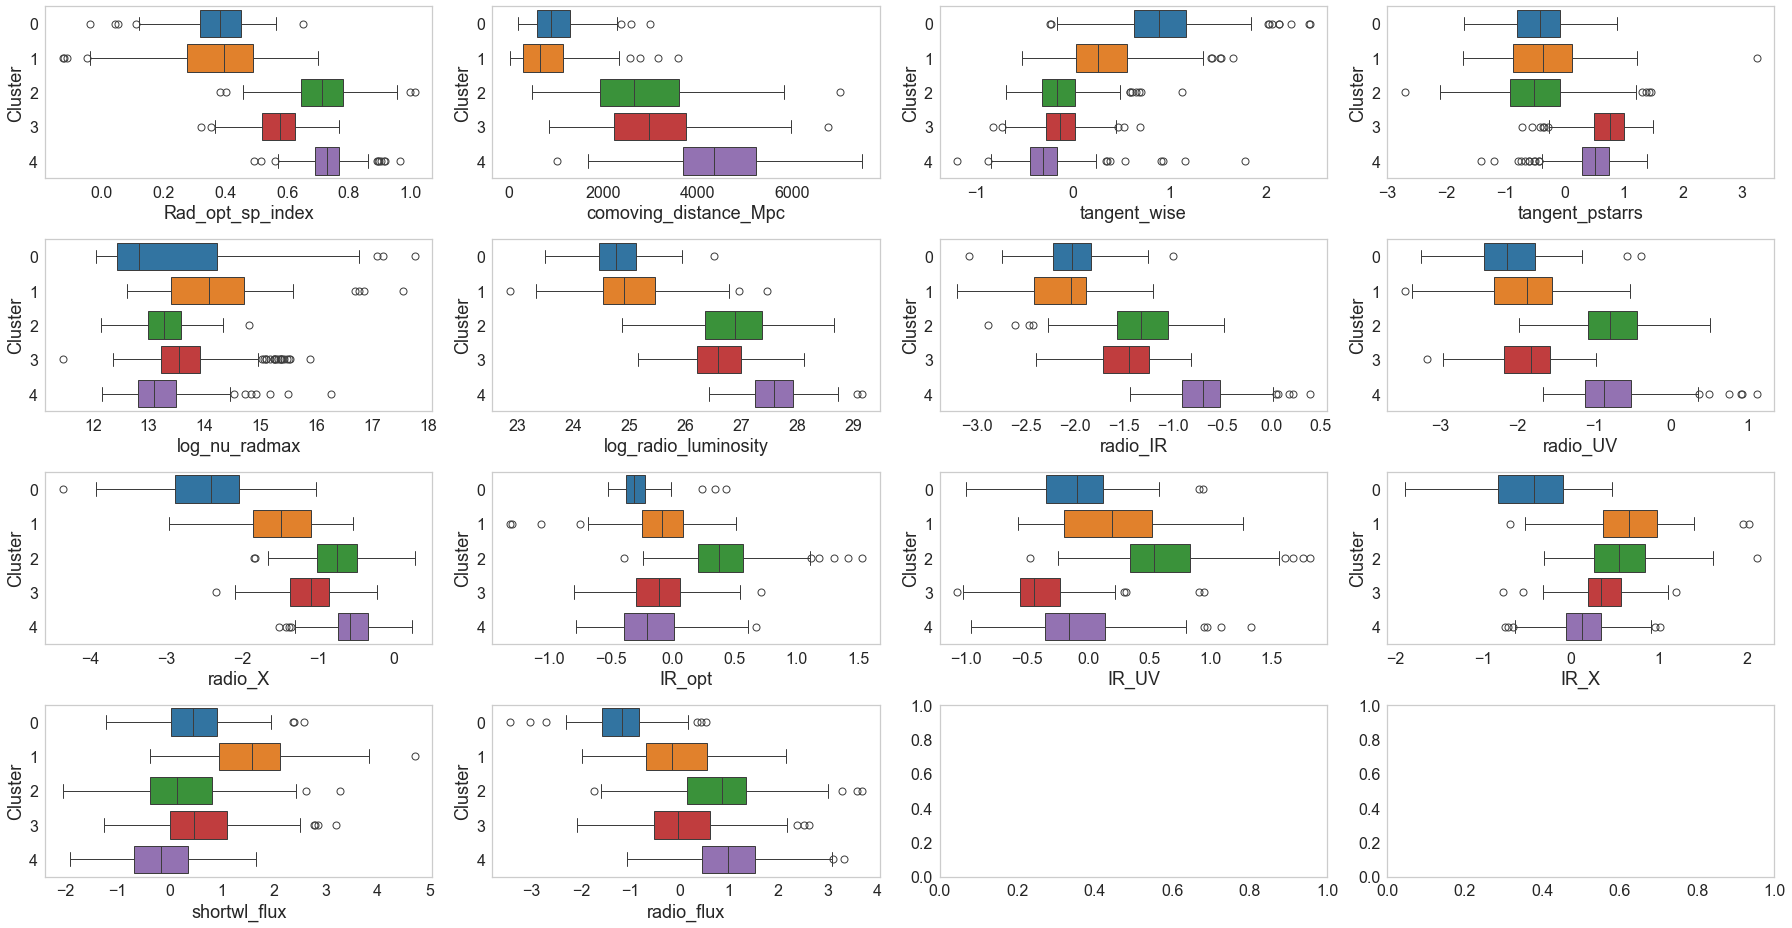

In [49]:
cols = model_df.columns #[:4]
plot_distr(bzcat_pca_dropna, cols, file='distr_nonan')

---

#### Output for self-organizing maps

In [50]:
model_pca_dropna.to_csv('data/model_df_nonans.csv', index_label='index')
model_pca_dropna

,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,log_radio_luminosity,radio_IR,radio_UV,radio_X,IR_opt,IR_UV,IR_X,shortwl_flux,radio_flux
12,0.521460,-0.011805,0.106515,1.814632,-1.003483,0.322437,-0.082478,-0.844870,0.070815,-0.066587,-1.196728,0.201472,0.205339,-0.042977
13,-0.911199,1.427421,0.092561,0.333401,0.801568,0.924665,-0.582892,-1.214784,-0.043872,-2.107484,-1.150866,0.621805,0.941548,-0.306463
14,0.250721,-1.151201,-1.067588,-1.970502,-0.327752,-0.551262,-0.557373,1.273176,0.209255,1.396119,2.640006,0.964719,0.607125,0.552025
15,1.158824,-0.874664,-0.620650,-0.880787,-0.622681,0.340370,0.323430,1.347501,0.884006,1.216287,1.673190,0.921636,0.734291,1.713167
21,-0.533293,0.906526,-1.037374,0.847744,-0.104837,1.097607,0.069527,-0.840961,0.489946,-1.228673,-1.377277,0.640024,0.777409,0.424484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,0.837322,2.045187,-0.883757,0.637972,-0.789137,1.674564,1.969671,2.000469,0.709721,-1.259207,0.655917,-1.273872,-0.939340,0.915913
3541,-0.065141,-0.118207,-0.305111,0.661940,0.003005,0.358444,0.532442,-0.289183,0.527624,-0.434861,-1.097724,0.150385,-0.165589,-0.024929
3551,1.373159,0.285142,-0.566909,0.078930,0.542684,0.995137,1.262012,0.982818,1.281914,0.309967,-0.038972,0.402600,-0.038031,1.412483
3556,0.572224,0.445654,-0.116906,1.279785,0.024266,0.827377,0.745771,-0.005168,0.803559,-0.143082,-0.923215,0.305729,-0.097421,0.728255


In [51]:
cols = ['BZCAT5 Source name']
cols.extend(model_pca_dropna.columns)
cols.append('cluster_kmeans')
bzcat_pca_dropna[cols].to_csv('data/bzcat_nonans.csv', index_label='index')
bzcat_pca_dropna[cols]

,BZCAT5 Source name,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,log_radio_luminosity,radio_IR,radio_UV,radio_X,IR_opt,IR_UV,IR_X,shortwl_flux,radio_flux,cluster_kmeans
12,5BZQJ0005-1648,0.686,2805.673389,0.090867,1.502494,12.617963,26.868469,-1.435105,-2.025364,-1.077369,-0.069401,-0.590259,0.357736,0.600814,0.254592,3
13,5BZQJ0005+0524,0.432,5140.351819,0.083485,0.363735,14.165780,27.581785,-1.740857,-2.308283,-1.165042,-0.799361,-0.567426,0.575815,1.314070,-0.039699,3
14,5BZQJ0005+3820,0.638,957.372355,-0.530242,-1.407489,13.197397,25.833606,-1.725265,-0.405426,-0.971537,0.453760,1.319838,0.753728,0.990074,0.919158,2
15,5BZBJ0006-0623,0.799,1405.963973,-0.293808,-0.569724,12.944497,26.889711,-1.187095,-0.348581,-0.455720,0.389440,0.838515,0.731375,1.113275,2.216054,2
21,5BZQJ0008-2339,0.499,4295.368264,-0.514259,0.759158,13.388545,27.786629,-1.342230,-2.022374,-0.756962,-0.485040,-0.680144,0.585268,1.155048,0.776706,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,5BZQJ2354-1513,0.742,6142.477121,-0.432994,0.597887,12.801763,28.470013,-0.181245,0.150826,-0.588954,-0.495960,0.332071,-0.407709,-0.508178,1.325590,4
3541,5BZUJ2354-0405,0.582,2633.069904,-0.126886,0.616313,13.481019,26.911119,-1.059389,-1.600360,-0.728158,-0.201120,-0.540970,0.331231,0.241450,0.274751,3
3551,5BZQJ2357-1125,0.837,3287.374180,-0.265379,0.168099,13.943789,27.665258,-0.613623,-0.627500,-0.151537,0.065280,-0.013876,0.462086,0.365032,1.880215,4
3556,5BZQJ2358+1955,0.695,3547.753027,-0.027325,1.091307,13.499250,27.466552,-0.929046,-1.383137,-0.517219,-0.096760,-0.454092,0.411827,0.307493,1.115992,4


In [52]:
cols = ['BZCAT5 Source name']
cols.extend(model_pca_dropna.columns)
#cols.extend(radio_vars)
#cols.extend(opt_vars)
cols.extend(shortwl_fluxes)
cols.extend(radio_fluxes)
cols.append('cluster_kmeans')
bzcat_pca_dropna[cols].to_csv('data/bzcat_extended.csv', index_label='index')
bzcat_pca_dropna[cols]

,BZCAT5 Source name,Rad_opt_sp_index,comoving_distance_Mpc,tangent_wise,tangent_pstarrs,log_nu_radmax,log_radio_luminosity,radio_IR,radio_UV,radio_X,...,log_nuF_i,log_nuF_z,log_nuF_y,log_nuF_w1,log_nuF_w2,log_nuF_w3,log_nuF_w4,log_nuF_1.4,log_nuF_4.8,cluster_kmeans
12,5BZQJ0005-1648,0.686,2805.673389,0.090867,1.502494,12.617963,26.868469,-1.435105,-2.025364,-1.077369,...,-11.929411,-11.898431,-12.058648,-12.015044,-11.998811,-12.148664,-12.042979,-13.433916,-12.918473,3
13,5BZQJ0005+0524,0.432,5140.351819,0.083485,0.363735,14.165780,27.581785,-1.740857,-2.308283,-1.165042,...,-11.209851,-11.250751,-11.281648,-11.859044,-12.009211,-11.965464,-11.978180,-13.750068,-12.943095,3
14,5BZQJ0005+3820,0.638,957.372355,-0.530242,-1.407489,13.197397,25.833606,-1.725265,-0.405426,-0.971537,...,-11.824971,-11.824351,-11.832768,-11.421844,-11.371211,-11.191464,-10.979379,-13.096476,-12.603147,2
15,5BZBJ0006-0623,0.799,1405.963973,-0.293808,-0.569724,12.944497,26.889711,-1.187095,-0.348581,-0.455720,...,-11.744251,-11.695871,-11.921528,-11.418244,-11.354811,-11.294264,-11.152979,-12.541906,-11.916085,2
21,5BZQJ0008-2339,0.499,4295.368264,-0.514259,0.759158,13.388545,27.786629,-1.342230,-2.022374,-0.756962,...,-11.452571,-11.551511,-11.611408,-12.095844,-11.937611,-11.743064,-11.656579,-13.279841,-12.594142,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3540,5BZQJ2354-1513,0.742,6142.477121,-0.432994,0.597887,12.801763,28.470013,-0.181245,0.150826,-0.588954,...,-12.239651,-12.281431,-12.275728,-12.729444,-12.735611,-12.515064,NaN,-12.916856,-12.391849,4
3541,5BZUJ2354-0405,0.582,2633.069904,-0.126886,0.616313,13.481019,26.911119,-1.059389,-1.600360,-0.728158,...,-12.020491,-11.996351,-12.080128,-12.248244,-12.221611,-12.253064,-12.112580,-13.281000,-13.007336,3
3551,5BZQJ2357-1125,0.837,3287.374180,-0.265379,0.168099,13.943789,27.665258,-0.613623,-0.627500,-0.151537,...,-12.046891,-12.085751,-12.056568,-12.054644,-11.981611,-11.969064,-11.796980,-12.595235,-12.156285,4
3556,5BZQJ2358+1955,0.695,3547.753027,-0.027325,1.091307,13.499250,27.466552,-0.929046,-1.383137,-0.517219,...,-12.000051,-12.124231,-12.127448,-12.196244,-12.096811,-12.127864,-12.142979,-13.025857,-12.489522,4


---

### 3.2. PPCA + KMeans (missing values are filled in using probabilistic PCA)

The probabilistic PCA is now apliied to the whole model dataframe to fill in the remained missing values

In [53]:
model_ppca = model_df.copy()
bzcat_ppca = bzcat.iloc[model_ppca.index,:].copy()

In [54]:
np.random.seed(42)

# Probabilistic PCA
# Number of latent variables is 7 (from the best Rand index)
Y = np.array(model_ppca)
C, ss, M, X, Ye = ppca(Y, 7, False)

## Deleting comoving distances after imputing
#Ye = np.delete(Ye, 1, 1)

# Scaling after PPCA
scaler3 = StandardScaler()
X = scaler3.fit_transform(Ye)
imputed_model_df = pd.DataFrame(X, columns=model_ppca.columns)

# PCA
pca2 = PCA(n_components=0.9, random_state=42)
X = pca2.fit_transform(X)
print(f'The number of principal components: {pca2.n_components_}')

pca_features = pd.DataFrame(X)  # PCA features dataframe 
with open('data/model/scaler3.pkl', 'wb') as f:
    pickle.dump(scaler3, f)
with open('data/model/pca2.pkl', 'wb') as f:
    pickle.dump(pca2, f)
    
imputed_model_df.to_csv('data/imputed_model_df.csv', index=False)

The number of principal components: 6


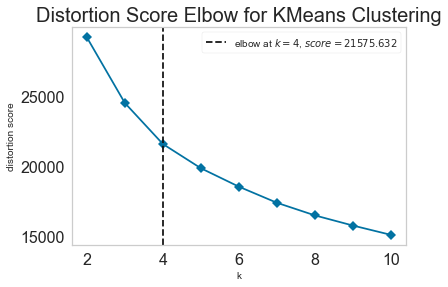

In [55]:
yb_elbow(X)

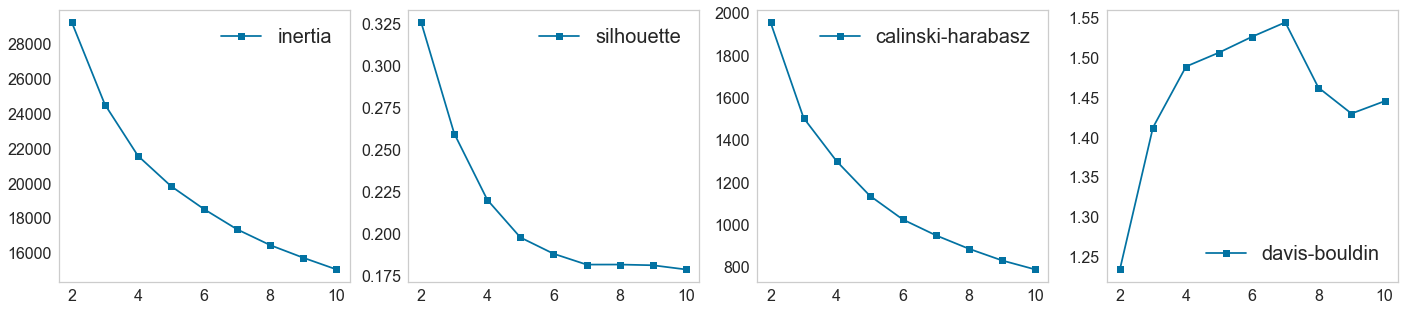

In [56]:
plot_metrics(X)

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



Silhouette: 0.198
Davis-Bouldin: 1.506
Calinski-Harabatz: 1136.943
Inertia: 19836.332
          0         1         2         3         4
0  0.000000  2.972793  6.103536  4.319661  6.092578
1  2.972793  0.000000  3.902606  3.037026  4.899111
2  6.103536  3.902606  0.000000  3.648713  3.164074
3  4.319661  3.037026  3.648713  0.000000  2.735806
4  6.092578  4.899111  3.164074  2.735806  0.000000


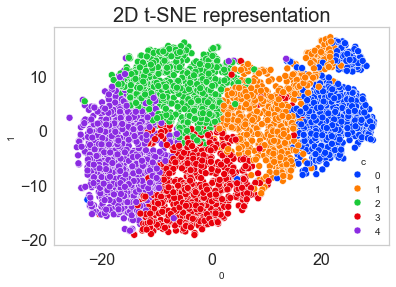

In [57]:
make_kmeans_clusters(X, bzcat_ppca, 5, 150)

The Rand index shows that after filling in the missing values using PPCA, 89.2% of the objects from the "no-nans" clustering have been indentified with the same groups. We tried other methods of imputing: medians and different ML regressions, but PPCA gives the best result in metrics and in the similaries of the distributions before and after the imputing of the missing values.

In [58]:
nonan_df = bzcat_ppca.loc[bzcat_pca_dropna.index]
print('Rand index: {:.4f}'.format(
    metrics.rand_score(bzcat_pca_dropna['cluster_kmeans'], nonan_df['cluster_kmeans'])))
print('V-measure: {:.4f}'.format(
    metrics.v_measure_score(bzcat_pca_dropna['cluster_kmeans'], nonan_df['cluster_kmeans'])))

Rand index: 0.8931
V-measure: 0.7111


Rand index for the comparison with SOM on the complete sample

In [59]:
som_imputed = pd.read_csv('data/SOM_clusters_imputed.csv')
print(metrics.rand_score(bzcat_ppca['cluster_kmeans'], som_imputed['cluster_SOM']))

0.9173750957084807


Reassigning cluster ordinal numbers so that they would correspond with the "no-nans" clustering.

In [60]:
bzcat_ppca['cluster_kmeans'].replace({0:0, 1:1, 2:2, 3:3, 4:4}, 
                                           inplace=True)


# for further classification of outliers (KNN traning dataset)
pca_features['cluster'] = bzcat_ppca['cluster_kmeans'].reset_index(drop=True)

/home/dkudr/miniconda3/envs/bzcat/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



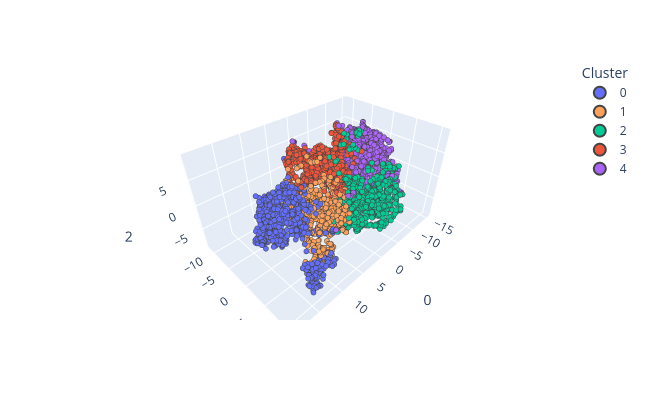

In [61]:
tsne = TSNE(n_components=3, perplexity=50, init='pca', learning_rate='auto', 
            random_state=42)
df_tsne = pd.DataFrame(tsne.fit_transform(X))
df_tsne['Cluster'] = bzcat_ppca.reset_index()['cluster_kmeans']
df_tsne['Cluster'] = df_tsne['Cluster'].astype('str')
fig = px.scatter_3d(df_tsne, x=0, y=1, z=2,
              color='Cluster', width=650, height=400,
              color_discrete_sequence=['#636EFA', '#FFA15A', '#00CC96',  '#EF553B',  '#AB63FA'],
              category_orders={'Cluster': ['0', '1', '2', '3', '4']})
fig.update_layout(legend= {'itemsizing': 'constant'})
fig.update_traces(marker={'size':3}, marker_line_width=0.5)
fig.write_html('figs/clusters_nonans.html')
fig.show('png')

Renewed cross-identification

In [62]:
pd.crosstab(
    bzcat_ppca['cluster_kmeans'], 
    bzcat_ppca['Class'], margins=True)

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,477,54,117,12,14,674
1,339,14,138,91,62,644
2,173,11,9,398,67,658
3,50,7,0,599,48,704
4,17,4,0,797,29,847
All,1056,90,264,1897,220,3527


Renewed distributions

(<Figure size 1800x936 with 16 Axes>,
 array([[<Axes: xlabel='Rad_opt_sp_index', ylabel='Cluster'>,
         <Axes: xlabel='comoving_distance_Mpc', ylabel='Cluster'>,
         <Axes: xlabel='tangent_wise', ylabel='Cluster'>,
         <Axes: xlabel='tangent_pstarrs', ylabel='Cluster'>],
        [<Axes: xlabel='log_nu_radmax', ylabel='Cluster'>,
         <Axes: xlabel='log_radio_luminosity', ylabel='Cluster'>,
         <Axes: xlabel='radio_IR', ylabel='Cluster'>,
         <Axes: xlabel='radio_UV', ylabel='Cluster'>],
        [<Axes: xlabel='radio_X', ylabel='Cluster'>,
         <Axes: xlabel='IR_opt', ylabel='Cluster'>,
         <Axes: xlabel='IR_UV', ylabel='Cluster'>,
         <Axes: xlabel='IR_X', ylabel='Cluster'>],
        [<Axes: xlabel='shortwl_flux', ylabel='Cluster'>,
         <Axes: xlabel='radio_flux', ylabel='Cluster'>, <Axes: >,
         <Axes: >]], dtype=object))

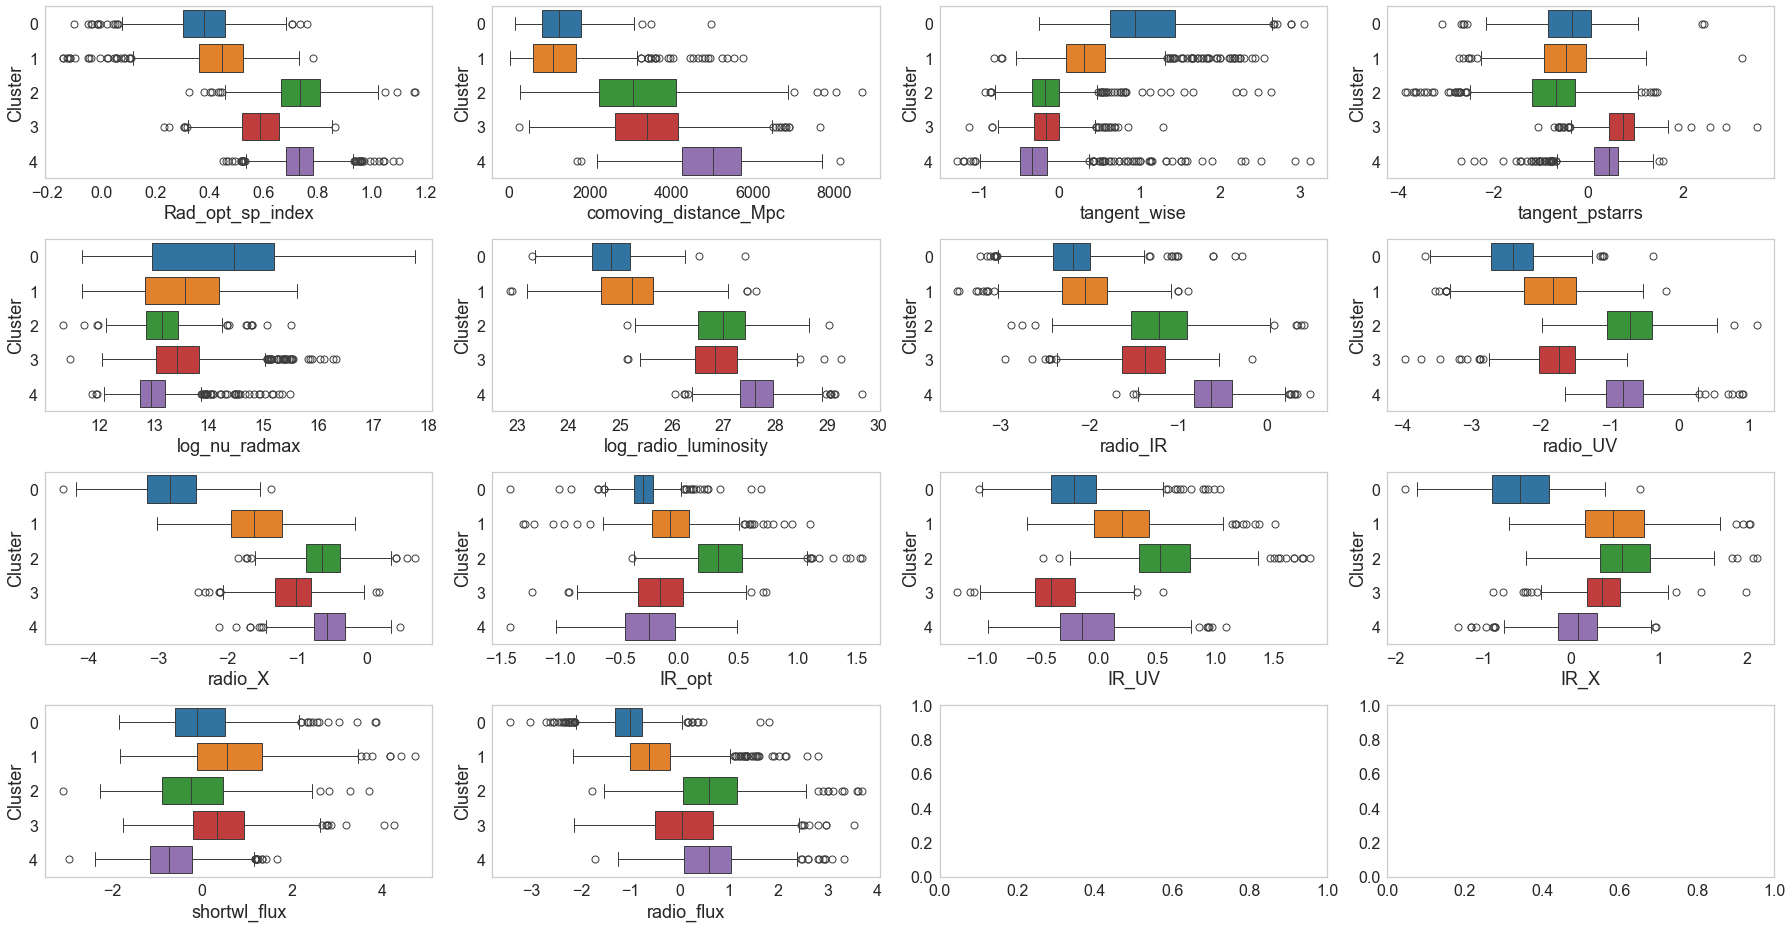

In [63]:
cols = model_df.columns #[:4]
plot_distr(bzcat_ppca, cols, file='distr_full')

In [64]:
cols_l = list(cols)
cols_l.append('cluster_kmeans')

compare_distribs = bzcat_ppca[cols_l].copy()
compare_distribs['Sample'] = 'Full'
compare_distribs = (pd.concat([compare_distribs, bzcat_pca_dropna[cols_l]])
                    .reset_index(drop=True))
compare_distribs.fillna({'Sample': 'Dropped'}, inplace=True)

In [65]:
compare_distribs.rename(
    columns={
        'Rad_opt_sp_index': 'Radio-to-opt. sp. index',
        'comoving_distance_Mpc': 'Distance, Mpc',
        'tangent_wise': 'Spectrum slope (WISE)',
        'tangent_pstarrs': 'Spectrum slope (Pan-STARRS)',
        'log_nu_radmax': r'$\log \nu_{\rm peak}$, [Hz]',
        'log_radio_luminosity': r'$\log L_{4.7}$, [W/Hz]',
        'radio_IR': 'radio/IR',
        'radio_UV': 'radio/UV',
        'radio_X': 'radio/X',
        'IR_opt': 'IR/opt',
        'IR_UV': 'IR/UV',
        'IR_X': 'IR/X',
        'shortwl_flux': r'$f_{\rm IR-X}$',
        'radio_flux': r'$f_{\rm radio}$'
        },
    inplace=True)

cols = list(compare_distribs.columns)
cols.remove('cluster_kmeans')
cols.remove('Sample')

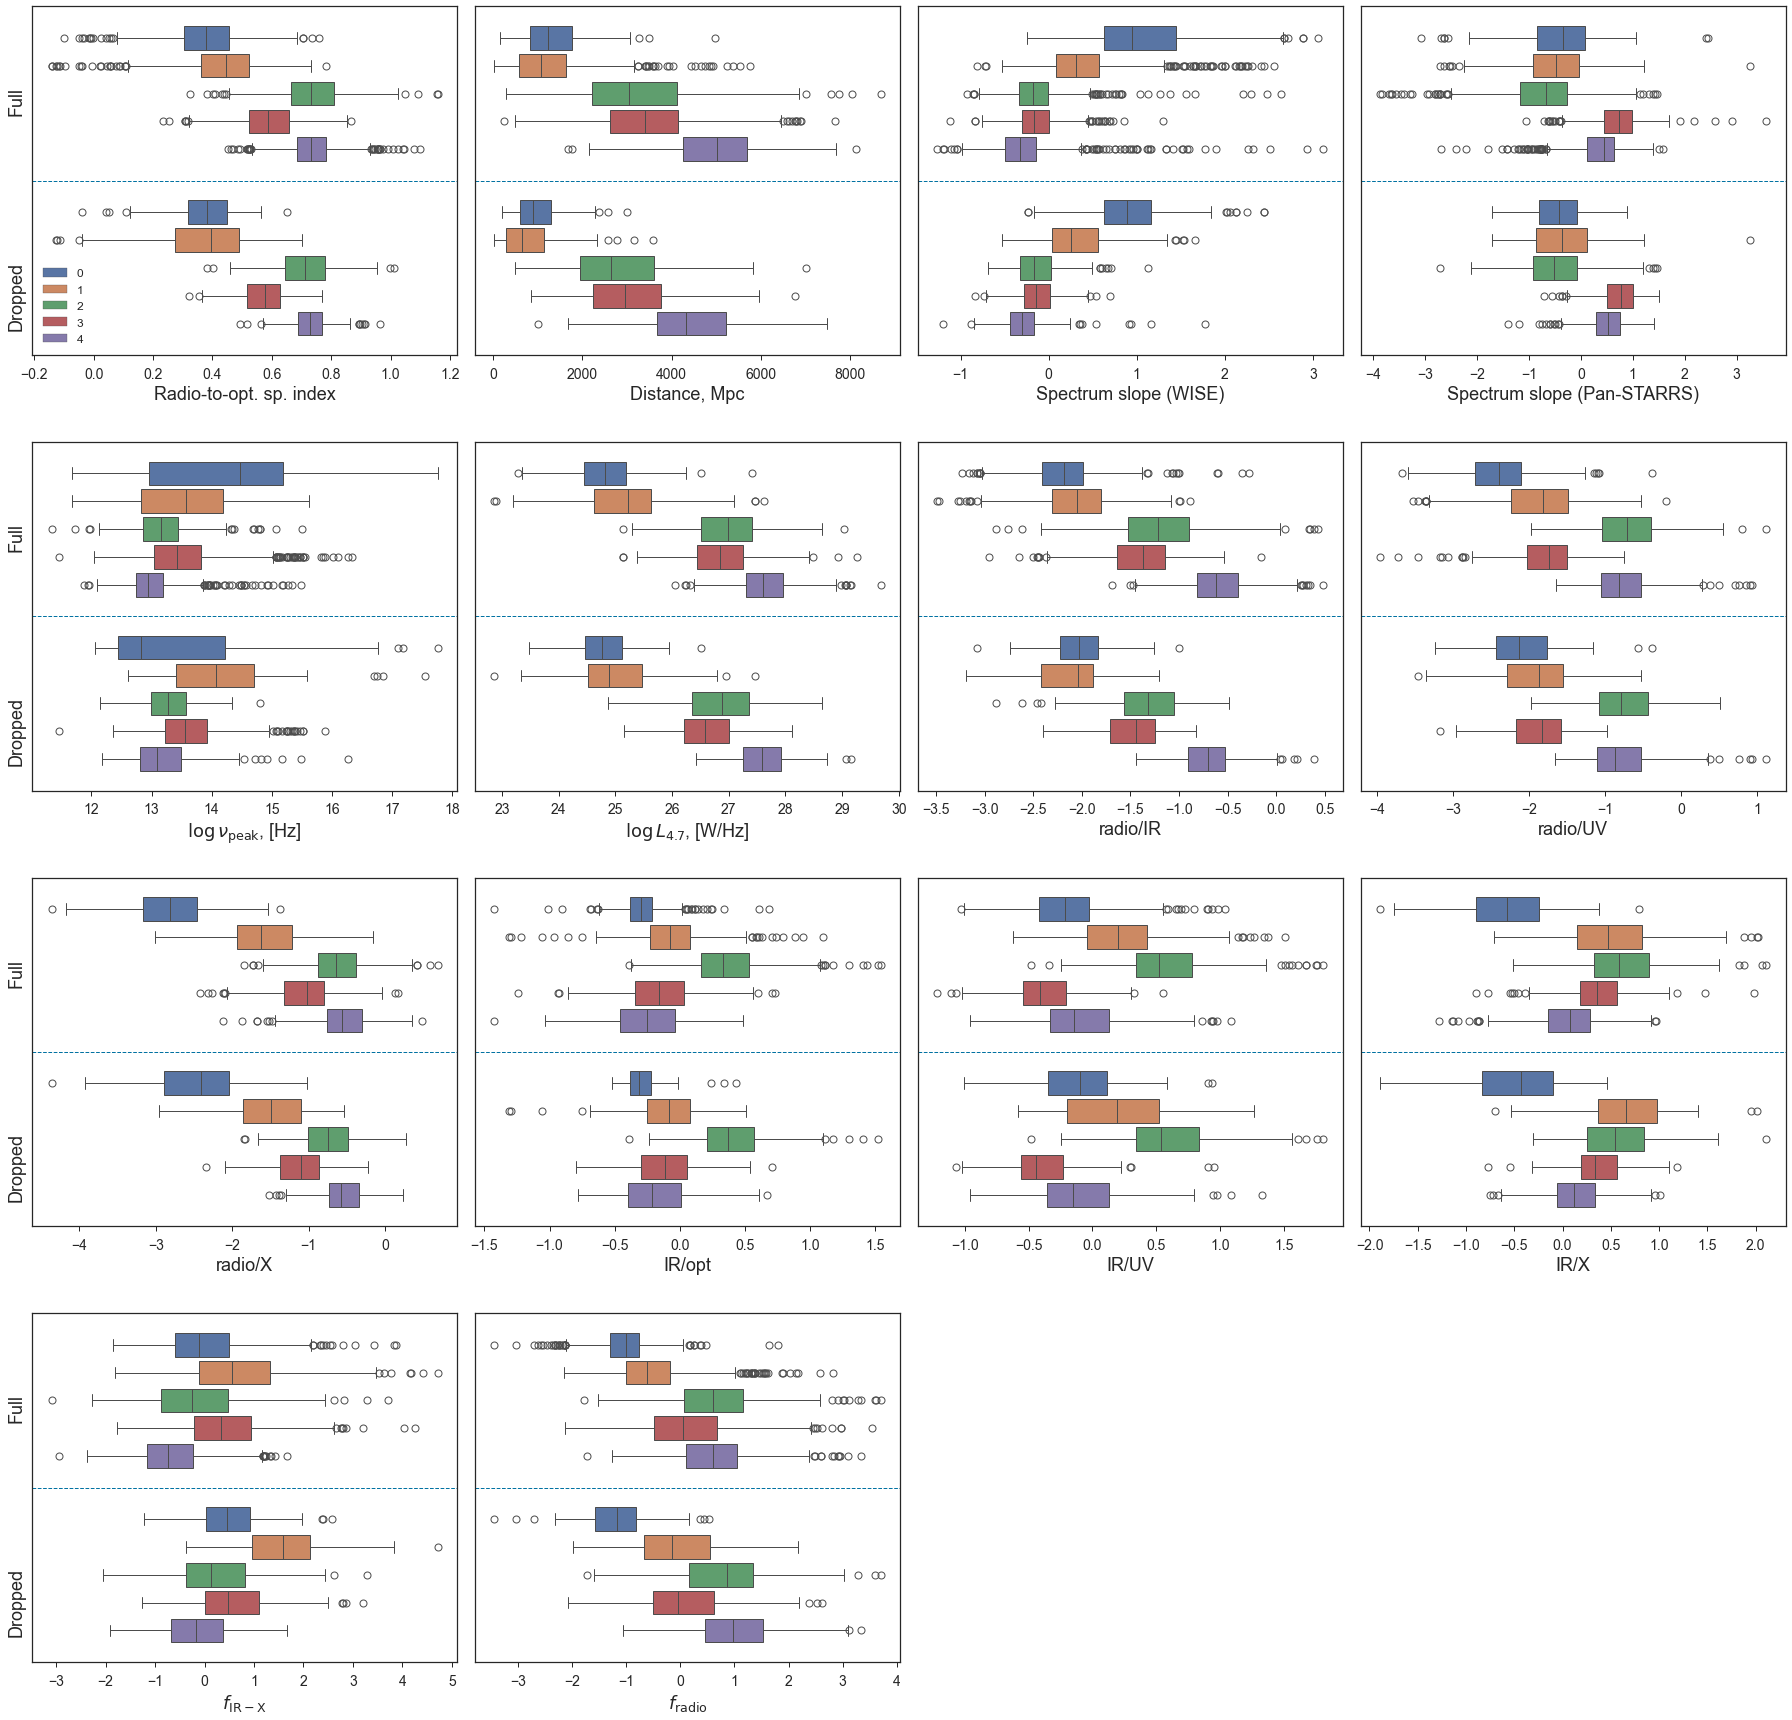

In [66]:
#sns.set_style({'axes.grid' : False})
sns.set_style("ticks")
plt.rcParams['xtick.major.size'] = 5


nrows = int(np.ceil(len(cols) / 4))
fig, axes = plt.subplots(nrows, 4, figsize=(25, 6*nrows), sharey=True)
i = 0
for col, ax in  zip(cols, axes.flatten()):
    sns.boxplot(
        data=compare_distribs, x=col, y='Sample', hue='cluster_kmeans',
        palette='deep',
        orient='h', gap=0.15, ax=ax).set(ylabel='')
    ax.tick_params(axis='y', labelsize=18, labelrotation=90)
    ax.tick_params(axis='x', labelsize=14, width=1)
    ax.xaxis.label.set_size(18)
    ax.axhline(0.5, linestyle='--', linewidth=1)
    if i == 0:
        ax.legend(loc='lower left', fontsize=12)
    else:
        ax.get_legend().remove()
    i += 1    
axes[3,2].remove()
axes[3,3].remove()
plt.tight_layout()
plt.subplots_adjust(
    #left=0.1,
    #bottom=0.1, 
    #right=0.9, 
    #top=0.9, 
    #wspace=0.05, 
    hspace=0.25)
plt.savefig('figs/distr_comparison.eps')

---

## 4. Anomalies classification

Now we need to classify the objects previously removed as outliers

### 4.1. Anomalies dataframe preprocessing

In [67]:
pca_features['cluster'] = pca_features['cluster'].astype(int)
pred_df = anomalies.drop(columns='Anomaly')

In [68]:
# Models
with open('data/model/scaler1.pkl', 'rb') as f:
    scaler1 = pickle.load(f)

#with open('data/model/pca1_radio_vars.pkl', 'rb') as f:
#    pca1_radio_vars = pickle.load(f)

#with open('data/model/pca1_opt_vars.pkl', 'rb') as f:
#    pca1_opt_vars = pickle.load(f)
    
with open('data/model/pca1_shortwl_fluxes.pkl', 'rb') as f:
    pca1_shortwl_fluxes = pickle.load(f)

with open('data/model/pca1_radio_fluxes.pkl', 'rb') as f:
    pca1_radio_fluxes = pickle.load(f)

with open('data/model/scaler2.pkl', 'rb') as f:
    scaler2 = pickle.load(f)
    
with open('data/model/scaler3.pkl', 'rb') as f:
    scaler3 = pickle.load(f)

with open('data/model/pca2.pkl', 'rb') as f:
    pca2 = pickle.load(f)

Here we cannot use probabilistic PCA, because we use a non-parametric implementation. Thus we cannot guess any missing values without applying the method to some dataset. Whatever dataset we could have used here, the data for the anomalous objects should be included in it, and thus it would be anyway a different dataset from our main model.

For that reason, the missing values here are filled in as follows:
1. For the first PCA step (e.g., "fluxes to flux"), we use the mean value over the corresponding columns (fluxes) for each object.
2. For the second PCA step (all other NaNs), the missing values are the mean values over a column (which is actually zero after the scaling).
3. Other transformations are from our main clustering model.

In [69]:
# First-step PCA for the anomalous objects

def cols_pca_transform(df, cols, pca_model):   
    X = df[cols].copy()
    
    # replace nans with the mean value in a row
    for col in cols:        
        X[col].fillna(np.mean(X[cols], axis=1), inplace=True) 
    
    # if nans are in all columns, the value to fill in 
    # doesn't actually matter (see the next step)
    X.fillna(0, inplace=True)  
    out_col = pca_model.transform(np.array(X)) 
    
    # result is nan if nans are in all columns
    out_col[df[cols].isnull().all(axis=1)] = np.NaN  
    return out_col

Applying consistently all the models according to the main clustering algorithm

In [70]:
pred_df = pd.DataFrame(scaler1.transform(pred_df),
                           columns=pred_df.columns)

#pred_df['radio_var'] = cols_pca_transform(
#    pred_df, radio_vars, pca1_radio_vars)
#pred_df['opt_var'] = cols_pca_transform(
#    pred_df, opt_vars, pca1_opt_vars)
pred_df['shortwl_flux'] = cols_pca_transform(
    pred_df, shortwl_fluxes, pca1_shortwl_fluxes)
pred_df['radio_flux'] = cols_pca_transform(
    pred_df, radio_fluxes, pca1_radio_fluxes)
#cols_drop = radio_vars+opt_vars+shortwl_fluxes+radio_fluxes
cols_drop = shortwl_fluxes+radio_fluxes
pred_df.drop(columns=cols_drop, inplace=True)

pred_df = pd.DataFrame(scaler2.transform(pred_df), 
                           columns=pred_df.columns) 
#new_cols = ['radio_var', 'opt_var',
#             'shortwl_flux', 'radio_flux']
new_cols = ['shortwl_flux', 'radio_flux']
anomalies[new_cols] = pred_df[new_cols]

pred_df.drop(columns=['alpha_2.3-4.8', 'alpha_4.8-7.7', 
                      'radio_radio'], 
             inplace=True)
pred_df = scaler3.transform(np.array(pred_df))

# NaNs to zero (the median values after scaling)
np.nan_to_num(pred_df, copy=False)
pred_df = pd.DataFrame(pca2.transform(pred_df))

### 4.2. KNN model

Multiclass K Nearest Neighbors model with a grid-search hyperparameter optimization (as the algorithm is fast enough). The F1-score for the test sample is about 0.93 (93% of the objects are identified correctly).

In [71]:
X = pca_features.drop(columns='cluster')
y = pca_features['cluster']
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42)

# Parameter grid
param_grid = [
    {'n_neighbors': range(5,100),
     'weights': ['uniform', 'distance']
    }
]

# Searching on the grid woth cross-validation (5 folds)
knn_model = model_selection.GridSearchCV(
    estimator = KNeighborsClassifier(), 
    param_grid=param_grid, 
    scoring = 'f1_micro',
    cv=5, 
    n_jobs = -1
)  
knn_model.fit(X_train, y_train) 
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
print('Train sample F1-score: {}'.
      format(metrics.f1_score(y_train, y_train_pred, average='micro')))
print('Test sample F1-score: {}'.
      format(metrics.f1_score(y_test, y_test_pred, average='micro')))
print(f'Best hyperparameters: {knn_model.best_params_}')
print(metrics.classification_report(y_test, y_test_pred))

Train sample F1-score: 1.0
Test sample F1-score: 0.9433427762039661
Best hyperparameters: {'n_neighbors': 70, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        67
           1       0.95      0.95      0.95        64
           2       0.94      0.89      0.91        66
           3       0.94      0.92      0.93        71
           4       0.92      0.98      0.95        85

    accuracy                           0.94       353
   macro avg       0.94      0.94      0.94       353
weighted avg       0.94      0.94      0.94       353



Making the final BZCAT dataset with all the objects, features, and cluster labels

In [72]:
anomalies['cluster_kmeans'] = knn_model.predict(pred_df)

anomalies['Class'] = bzcat['Class']
anomalies['is_TeV'] = bzcat['is_TeV']
anomalies['is_HSP'] = bzcat['is_HSP']
#anomalies['BZCAT5 Source name'] = bzcat['BZCAT5 Source name']
final_df = pd.concat([bzcat_ppca, anomalies]).sort_index()
final_df.to_csv('data/BZCAT_clusters.csv', index=False)

Cross-identification for the final dataset

In [73]:
final_df = pd.read_csv('data/BZCAT_clusters.csv')

crosstab = pd.crosstab(
    final_df['cluster_kmeans'], 
    final_df['Class'], margins=True)
crosstab

Class,BLLac,BLLac_c,BZG,BZQ,BZU,All
cluster_kmeans,,,,,,
0,480,55,122,12,14,683
1,339,14,141,91,64,649
2,173,11,10,403,70,667
3,50,8,1,602,49,710
4,17,4,0,801,30,852
All,1059,92,274,1909,227,3561


In [74]:
hsp_tev = pd.DataFrame()
hsp_tev['TeV'] = final_df[final_df['is_TeV']].groupby('cluster_kmeans')['is_TeV'].count()
hsp_tev['HSP'] = final_df[final_df['is_HSP']].groupby('cluster_kmeans')['is_HSP'].count()

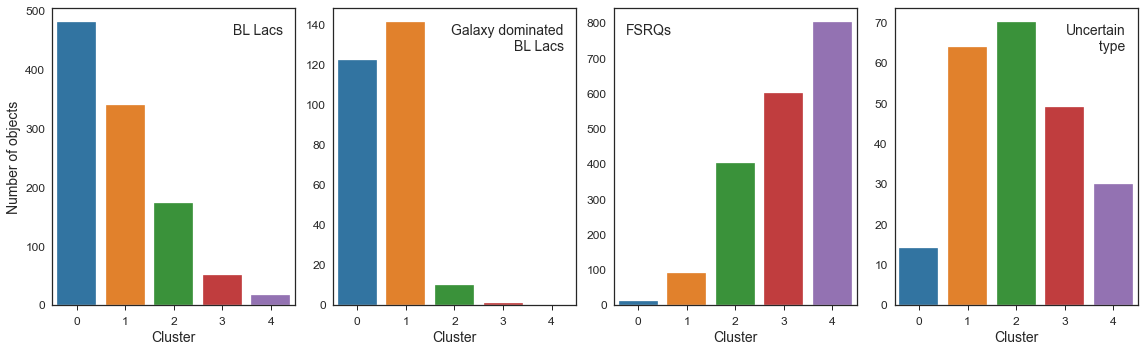

In [75]:
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots(1, 4, figsize=(16, 5))

sns.barplot(
    data=crosstab[:5], x=crosstab[:5].index, y='BLLac', ax=ax[0], 
    hue=crosstab[:5].index, palette='tab10')
ax[0].get_legend().remove()
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Number of objects')
ax[0].text(.95,.95, 'BL Lacs', fontsize=14,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[0].transAxes)

sns.barplot(
    data=crosstab[:5], x=crosstab[:5].index, y='BZG', ax=ax[1], 
    hue=crosstab[:5].index, palette='tab10')
ax[1].get_legend().remove()
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('')
ax[1].text(.95,.95, 'Galaxy dominated\nBL Lacs', fontsize=14,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[1].transAxes)

sns.barplot(
    data=crosstab[:5], x=crosstab[:5].index, y='BZQ', ax=ax[2], 
    hue=crosstab[:5].index, palette='tab10')
ax[2].get_legend().remove()
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('')
ax[2].text(.05,.95, 'FSRQs', fontsize=14,
           horizontalalignment='left', verticalalignment='top',
           transform=ax[2].transAxes)

sns.barplot(
    data=crosstab[:5], x=crosstab[:5].index, y='BZU', ax=ax[3], 
    hue=crosstab[:5].index, palette='tab10')
ax[3].get_legend().remove()
ax[3].set_xlabel('Cluster')
ax[3].set_ylabel('')
ax[3].text(.95,.95, 'Uncertain\n type', fontsize=14,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[3].transAxes)

plt.tight_layout()
plt.savefig('figs/cross_ident.png', format='png')
plt.savefig('figs/cross_ident.eps', format='eps')
#plt.rcParams['axes.labelsize'] = 10
#plt.rcParams['xtick.labelsize'] = 8
#plt.rcParams['ytick.labelsize'] = 8

(<Figure size 1800x936 with 16 Axes>,
 array([[<Axes: xlabel='Rad_opt_sp_index', ylabel='Cluster'>,
         <Axes: xlabel='comoving_distance_Mpc', ylabel='Cluster'>,
         <Axes: xlabel='tangent_wise', ylabel='Cluster'>,
         <Axes: xlabel='tangent_pstarrs', ylabel='Cluster'>],
        [<Axes: xlabel='log_nu_radmax', ylabel='Cluster'>,
         <Axes: xlabel='log_radio_luminosity', ylabel='Cluster'>,
         <Axes: xlabel='radio_IR', ylabel='Cluster'>,
         <Axes: xlabel='radio_UV', ylabel='Cluster'>],
        [<Axes: xlabel='radio_X', ylabel='Cluster'>,
         <Axes: xlabel='IR_opt', ylabel='Cluster'>,
         <Axes: xlabel='IR_UV', ylabel='Cluster'>,
         <Axes: xlabel='IR_X', ylabel='Cluster'>],
        [<Axes: xlabel='shortwl_flux', ylabel='Cluster'>,
         <Axes: xlabel='radio_flux', ylabel='Cluster'>, <Axes: >,
         <Axes: >]], dtype=object))

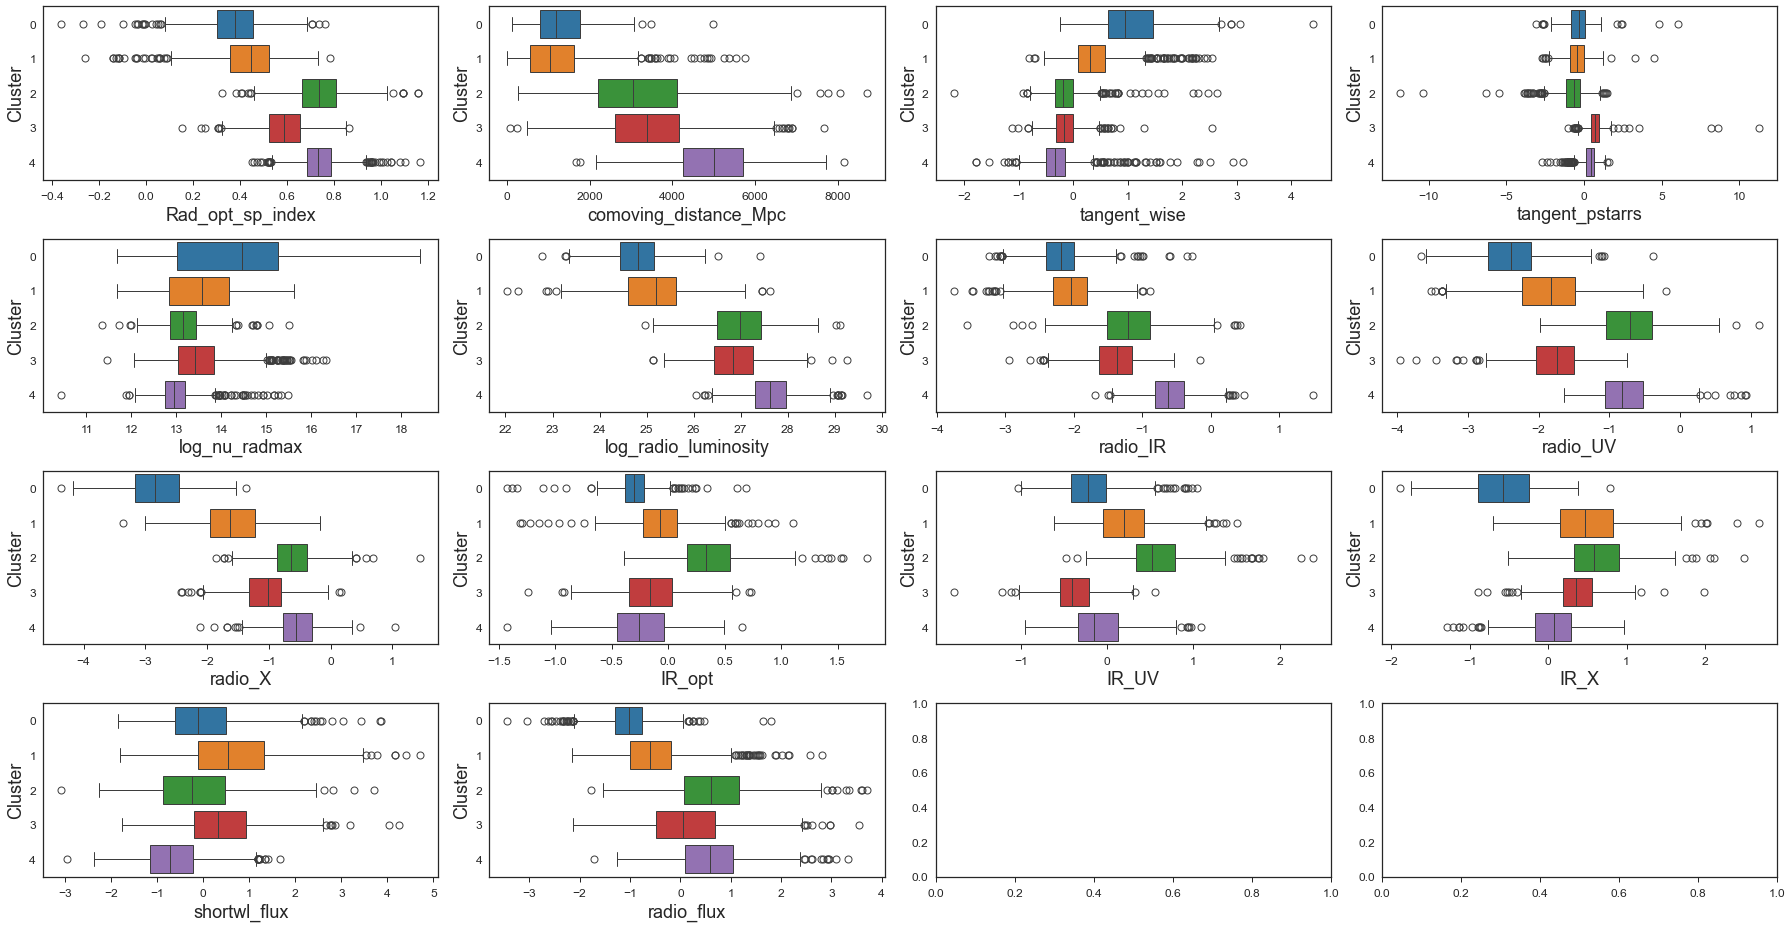

In [76]:
cols = model_df.columns #[:4]
plot_distr(final_df, cols, file='distr_with_extrem_obj')

In [77]:
hsp_tev

,TeV,HSP
cluster_kmeans,,
0,16,529
1,13,118
2,5,2
3,3,6
4,1,2


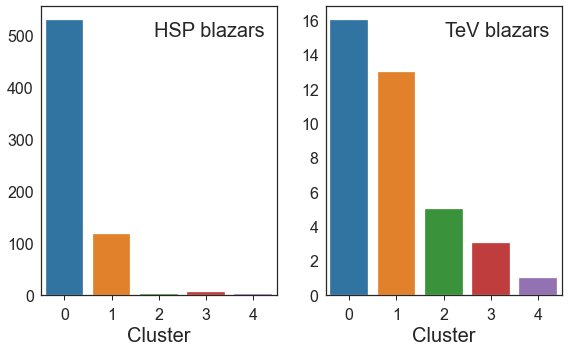

In [78]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

sns.barplot(
    data=hsp_tev, x=hsp_tev.index, y='HSP', ax=ax[0],
    hue=crosstab[:5].index, palette='tab10')
ax[0].get_legend().remove()
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('')
ax[0].text(.95,.95, 'HSP blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[0].transAxes)

sns.barplot(
    data=hsp_tev, x=hsp_tev.index, y='TeV', ax=ax[1],
    hue=crosstab[:5].index, palette='tab10')
ax[1].get_legend().remove()
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('')
ax[1].text(.95,.95, 'TeV blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[1].transAxes)

plt.tight_layout()
plt.savefig('figs/hsp_tev.png', format='png')
plt.savefig('figs/hsp_tev.eps', format='eps')


In [79]:
#hsp_tev['All'] = crosstab['All'][:5]
#hsp_tev['TeV_frac'] = hsp_tev['TeV'] / hsp_tev['All'] * 100
#hsp_tev['HSP_frac'] = hsp_tev['HSP'] / hsp_tev['All'] * 100

hsp_tev['TeV_frac'] = hsp_tev['TeV'] / hsp_tev['TeV'].sum() * 100
hsp_tev['HSP_frac'] = hsp_tev['HSP'] / hsp_tev['HSP'].sum() * 100

hsp_tev

,TeV,HSP,TeV_frac,HSP_frac
cluster_kmeans,,,,
0,16,529,42.105263,80.517504
1,13,118,34.210526,17.960426
2,5,2,13.157895,0.304414
3,3,6,7.894737,0.913242
4,1,2,2.631579,0.304414


Text(0.95, 0.95, 'TeV blazars')

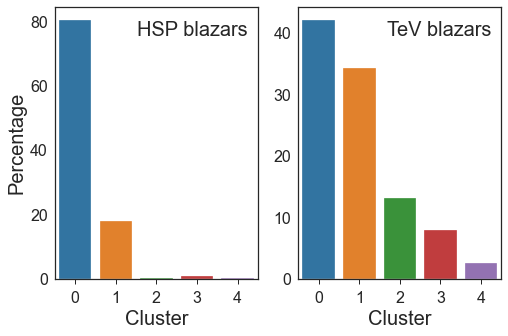

In [80]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots(1, 2, figsize=(8, 5))

sns.barplot(
    data=hsp_tev, x=hsp_tev.index, y='HSP_frac', ax=ax[0],
    hue=crosstab[:5].index, palette='tab10')
ax[0].get_legend().remove()
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('Percentage')
ax[0].text(.95,.95, 'HSP blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[0].transAxes)

sns.barplot(
    data=hsp_tev, x=hsp_tev.index, y='TeV_frac', ax=ax[1],
    hue=crosstab[:5].index, palette='tab10')
ax[1].get_legend().remove()
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('')
ax[1].text(.95,.95, 'TeV blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[1].transAxes)

In [81]:
types_tab = crosstab[:5].copy()
types_tab['BLLacs'] = types_tab['BLLac'] + types_tab['BZG']
types_tab['TeV'] = hsp_tev['TeV']
types_tab['HSP'] = hsp_tev['HSP']

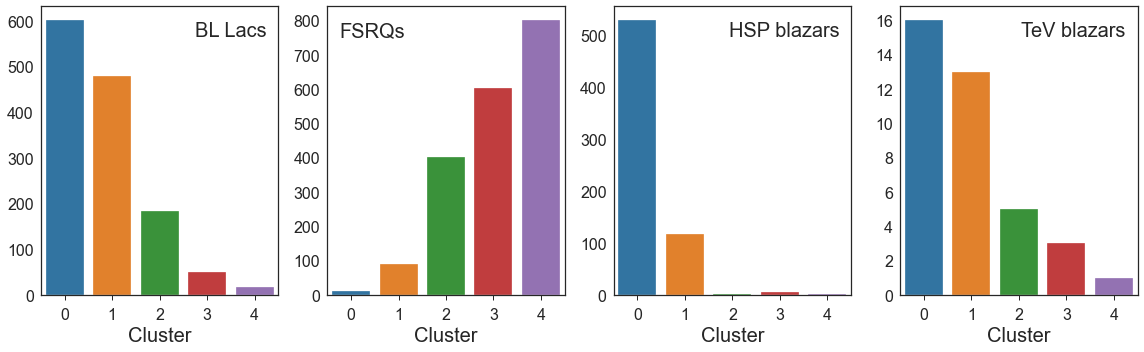

In [82]:
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
sns.set_style({'axes.grid' : False})
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
#fig, ax = plt.subplots(1, 2, figsize=(8, 5))

sns.barplot(
    data=types_tab, x=types_tab.index, y='BLLacs', ax=ax[0],
    hue=types_tab.index, palette='tab10')
ax[0].get_legend().remove()
ax[0].set_xlabel('Cluster')
ax[0].set_ylabel('')
ax[0].text(.95,.95, 'BL Lacs', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[0].transAxes)

sns.barplot(
    data=types_tab, x=types_tab.index, y='BZQ', ax=ax[1],
    hue=types_tab.index, palette='tab10')
ax[1].get_legend().remove()
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('')
ax[1].text(.05,.95, 'FSRQs', fontsize=20,
           horizontalalignment='left', verticalalignment='top',
           transform=ax[1].transAxes)

sns.barplot(
    data=types_tab, x=types_tab.index, y='HSP', ax=ax[2],
    hue=types_tab.index, palette='tab10')
ax[2].get_legend().remove()
ax[2].set_xlabel('Cluster')
ax[2].set_ylabel('')
ax[2].text(.95,.95, 'HSP blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[2].transAxes)

sns.barplot(
    data=hsp_tev, x=hsp_tev.index, y='TeV', ax=ax[3],
    hue=types_tab.index, palette='tab10')
ax[3].get_legend().remove()
ax[3].set_xlabel('Cluster')
ax[3].set_ylabel('')
ax[3].text(.95,.95, 'TeV blazars', fontsize=20,
           horizontalalignment='right', verticalalignment='top',
           transform=ax[3].transAxes)

plt.tight_layout()
plt.savefig('figs/types.png', format='png')

In [83]:
cl = 1
final_df[final_df['cluster_kmeans']==cl][['log_radio_luminosity']].describe()

,log_radio_luminosity
count,306.000000
mean,25.122479
std,0.847261
min,22.037353
25%,24.606483
50%,25.205051
75%,25.630084
max,27.626618


In [84]:
list(final_df.columns)

['BZCAT5 Source name',
 'RA (J2000.0)',
 'Dec (J2000.0)',
 'Redshift',
 'Class',
 'Rad_opt_sp_index',
 'alpha_1.1-2.3',
 'alpha_2.3-4.8',
 'alpha_4.8-7.7',
 'alpha_4.8-11.2',
 'alpha_7.7-11.2',
 'alpha_11.2-21.7',
 'alpha_7.7-21.7',
 'alpha_4.8-21.7',
 'var_1.1',
 'var_2.3',
 'var_4.8',
 'var_7.7',
 'var_11.2',
 'var_21.7',
 'is_TeV',
 'is_HSP',
 'universe_age_Gyr',
 'comoving_distance_Mpc',
 'lookback_distance_Mpc',
 'luminosity_distance_Mpc',
 'distance_modulus_mag',
 'RA_sin',
 'RA_cos',
 'Dec_sin',
 'ext_fuv',
 'ext_nuv',
 'log_nuF_fuv',
 'log_nuF_nuv',
 'log_nuF_g',
 'log_nuF_r',
 'log_nuF_i',
 'log_nuF_z',
 'log_nuF_y',
 'log_nuF_Su',
 'log_nuF_Sg',
 'log_nuF_Sr',
 'log_nuF_Si',
 'log_nuF_Sz',
 'log_nuF_J',
 'log_nuF_H',
 'log_nuF_K',
 'log_nuF_w1',
 'log_nuF_w2',
 'log_nuF_w3',
 'log_nuF_w4',
 'tangent_wise',
 'tangent_pstarrs',
 'log_nu_radmax',
 'nuv_abs',
 'i_abs',
 'w1_abs',
 'log_X_luminosity_W',
 'log_nuF_X',
 'log_gamma_luminosity_ph',
 'log_nuF_gamma',
 'log_radio_lumino

In [85]:
px.box(final_df, y='log_X_luminosity_W', x='cluster_kmeans')

<Axes: xlabel='log_radio_luminosity', ylabel='BL Lacs'>

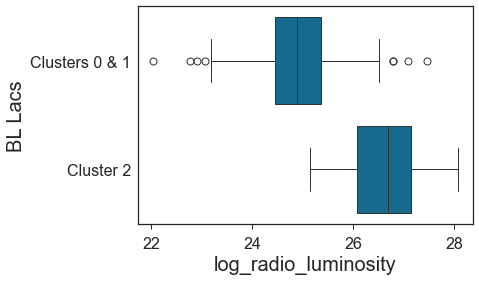

In [86]:
def lclass(x):
    mask1 = (x['cluster_kmeans']==0) | (x['cluster_kmeans']==1)
    mask2 = (x['cluster_kmeans']==2)
    mask3 = (x['Class']=='BLLac') | (x['Class']=='BZG')
    if mask1 and mask3:
        x['BL Lacs'] = 'Clusters 0 & 1'
    if mask2 and mask3:
        x['BL Lacs'] = 'Cluster 2'
    
    return x


tmp_tab = final_df.copy()
tmp_tab = tmp_tab.apply(lclass, axis=1)
tmp_tab.dropna(subset='BL Lacs', inplace=True)


sns.boxplot(data=tmp_tab, x='log_radio_luminosity', y='BL Lacs')

In [87]:
fig = px.histogram(
    tmp_tab, x='log_radio_luminosity', color='BL Lacs', 
    barmode='overlay', marginal='box', nbins=30)

fig.update_layout(
    autosize=False,
    width=650,
    height=400,
    margin=dict(l=20, r=20, t=20, b=20)
)

fig.update_xaxes(title_text='Log radio luminosity, [W/Hz]', row=1, col=1)
fig.update_yaxes(title_text='No. of objects', row=1, col=1)
fig.write_image('figs/BLLacs_lum.png')
fig.show()

---

## 5. Diagrams

### 5.1 Feature distribution in clusters

The function displays distributions of a feature in clusters.

In [88]:
def look_distr(df, col, xlim=None, file=None):
    "Feature distributions in clusters"
    #plt.rcParams['axes.labelsize'] = 18
    #sns.set_style({'axes.grid' : False})
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=col, y='cluster_kmeans', 
                orient='h').set(ylabel='Cluster')
    if not xlim is None:
        plt.xlim(xlim)    
    if file is not None:
        plt.savefig('figs/' + file + '.eps', format='eps', bbox_inches='tight')       
    plt.rcParams['axes.labelsize'] = 10

In [89]:
look_df = pd.read_csv('data/BZCAT_clusters.csv')

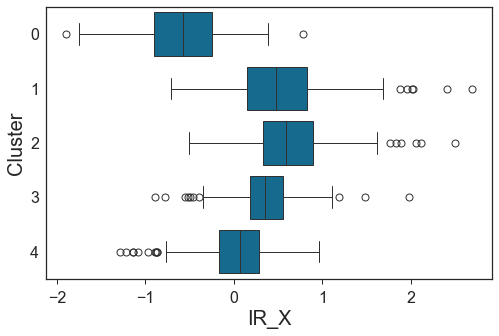

In [90]:
look_df['radio_IR'] = look_df['log_nuF_1.4'] - look_df['log_nuF_w2']
look_df['radio_opt'] = look_df['log_nuF_1.4'] - look_df['log_nuF_i']
look_df['radio_UV'] = look_df['log_nuF_1.4'] - look_df['log_nuF_nuv']
look_df['radio_X'] = look_df['log_nuF_1.4'] - look_df['log_nuF_X']
look_df['radio_gamma'] = look_df['log_nuF_1.4'] - look_df['log_nuF_gamma']

look_df['IR_radio'] = look_df['log_nuF_w2'] - look_df['log_nuF_1.4']
look_df['IR_opt'] = look_df['log_nuF_w2'] - look_df['log_nuF_i']
look_df['IR_UV'] = look_df['log_nuF_w2'] - look_df['log_nuF_nuv']
look_df['IR_X'] = look_df['log_nuF_w2'] - look_df['log_nuF_X']
look_df['IR_gamma'] = look_df['log_nuF_w2'] - look_df['log_nuF_gamma']

look_df['opt_radio'] = look_df['log_nuF_i'] - look_df['log_nuF_1.4']
look_df['opt_IR'] = look_df['log_nuF_i'] - look_df['log_nuF_w2']
look_df['opt_UV'] = look_df['log_nuF_i'] - look_df['log_nuF_nuv']
look_df['opt_X'] = look_df['log_nuF_i'] - look_df['log_nuF_X']
look_df['opt_gamma'] = look_df['log_nuF_i'] - look_df['log_nuF_gamma']

look_df['UV_radio'] = look_df['log_nuF_nuv'] - look_df['log_nuF_1.4']
look_df['UV_IR'] = look_df['log_nuF_nuv'] - look_df['log_nuF_w2']
look_df['UV_opt'] = look_df['log_nuF_nuv'] - look_df['log_nuF_i']
look_df['UV_X'] = look_df['log_nuF_nuv'] - look_df['log_nuF_X']
look_df['UV_gamma'] = look_df['log_nuF_nuv'] - look_df['log_nuF_gamma']

look_df['X_radio'] = look_df['log_nuF_X'] - look_df['log_nuF_1.4']
look_df['X_IR'] = look_df['log_nuF_X'] - look_df['log_nuF_w2']
look_df['X_opt'] = look_df['log_nuF_X'] - look_df['log_nuF_i']
look_df['X_UV'] = look_df['log_nuF_X'] - look_df['log_nuF_nuv']
look_df['X_gamma'] = look_df['log_nuF_X'] - look_df['log_nuF_gamma']

look_df['gamma_radio'] = look_df['log_nuF_gamma'] - look_df['log_nuF_1.4']
look_df['gamma_IR'] = look_df['log_nuF_gamma'] - look_df['log_nuF_w2']
look_df['gamma_opt'] = look_df['log_nuF_gamma'] - look_df['log_nuF_i']
look_df['gamma_UV'] = look_df['log_nuF_gamma'] - look_df['log_nuF_nuv']
look_df['gamma_X'] = look_df['log_nuF_gamma'] - look_df['log_nuF_X']



#look_distr(look_df, 'Redshift', [0, 1])
#mask = look_df['Class'] == 'BLLac'
look_distr(look_df, 'IR_X')

In [91]:
look_df

,BZCAT5 Source name,RA (J2000.0),Dec (J2000.0),Redshift,Class,Rad_opt_sp_index,alpha_1.1-2.3,alpha_2.3-4.8,alpha_4.8-7.7,alpha_4.8-11.2,...,UV_opt,X_radio,X_IR,X_opt,X_UV,gamma_radio,gamma_IR,gamma_opt,gamma_UV,gamma_X
0,5BZQJ0000-3221,00 00 20.39,-32 21 01.0,1.275,BZQ,0.707,NaN,0.056,-0.763,NaN,...,NaN,-0.163996,-0.966619,NaN,-1.401524,NaN,NaN,NaN,NaN,NaN
1,5BZQJ0001-1551,00 01 05.29,-15 51 06.98,2.044,BZQ,0.661,NaN,-0.281,-0.599,-0.788,...,-0.210538,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5BZQJ0001+1914,00 01 08.62,+19 14 34.18,3.100,BZQ,0.917,-0.117,0.029,0.276,-0.427,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5BZBJ0001-0746,00 01 18.0,-07 46 26.68,NaN,BLLac,0.553,NaN,-0.029,-0.159,-0.484,...,-0.277116,1.079877,-0.803921,-0.847041,-0.569925,3.138460,1.254662,1.211543,1.488658,2.058583
4,5BZBJ0001-0011,00 01 21.48,-00 11 39.91,0.462,BLLac,0.706,NaN,-0.560,-0.501,-0.592,...,-0.169172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3556,5BZQJ2358+1955,23 58 46.08,+19 55 20.31,1.066,BZQ,0.695,NaN,0.032,-0.483,-0.446,...,0.357331,0.517219,-0.411827,-0.508587,-0.865919,NaN,NaN,NaN,NaN,NaN
3557,5BZQJ2358+3922,23 58 59.86,+39 22 28.3,1.201,BZQ,0.737,NaN,-0.060,-2.171,-0.290,...,-0.136533,0.831650,0.006471,0.239431,0.375964,NaN,NaN,NaN,NaN,NaN
3558,5BZBJ2359-3037,23 59 07.91,-30 37 41.41,0.165,BLLac,0.304,NaN,NaN,NaN,NaN,...,NaN,3.665706,1.457037,NaN,1.128331,3.743313,1.534644,NaN,1.205938,0.077607
3559,5BZQJ2359+3850,23 59 33.18,+38 50 42.28,2.711,BZQ,0.745,NaN,0.109,-2.202,0.361,...,NaN,0.842111,0.611181,0.053861,NaN,NaN,NaN,NaN,NaN,NaN


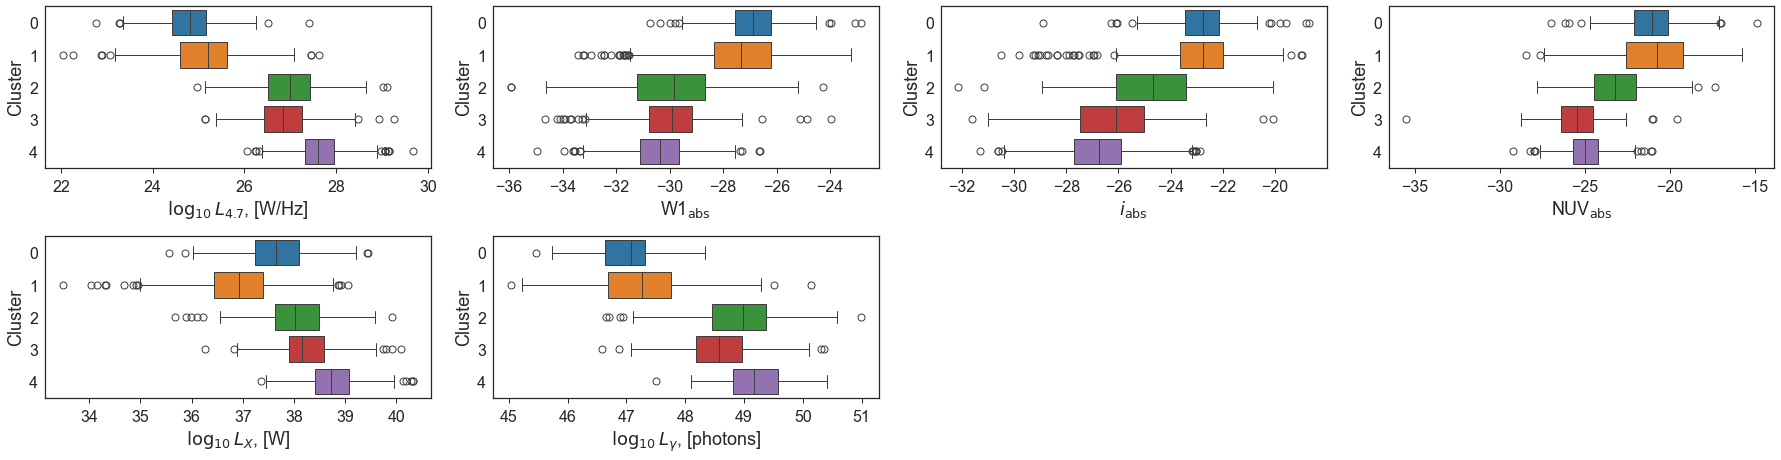

In [92]:
#r'$\log L_{4.7}$, [W/Hz]'
look_df = pd.read_csv('data/BZCAT_clusters.csv')
cols = ['log_radio_luminosity', 'w1_abs', 'i_abs', 'nuv_abs', 
        'log_X_luminosity_W', 'log_gamma_luminosity_ph', 'cluster_kmeans']
look_df = look_df[cols]
look_df.rename(
    columns={
        'log_radio_luminosity': r'$\log_{10} L_{4.7}$, [W/Hz]',
        'w1_abs': r'W1$_{\rm abs}$',
        'i_abs': r'$i_{\rm abs}$',
        'nuv_abs': r'NUV$_{\rm abs}$',
        'log_X_luminosity_W': r'$\log_{10} L_X$, [W]',
        'log_gamma_luminosity_ph': r'$\log_{10} L_\gamma$, [photons]',
        },
    inplace=True)
fig, axes = plot_distr(look_df, look_df.columns)
axes[1,2].remove()
axes[1,3].remove()
plt.savefig('figs/luminocities.eps')
plt.savefig('figs/luminocities.png')

### 5.2 Polar diagrams

In [93]:
cols =[
    'IR_UV', 'IR_opt', 'IR_X', 'radio_UV', 'radio_flux', 'radio_X',
    'Rad_opt_sp_index', 'log_radio_luminosity', 
    'w1_abs', 'i_abs', 'nuv_abs', 'log_X_luminosity_W', 'log_gamma_luminosity_ph', 
    'radio_IR', 'comoving_distance_Mpc', 
    #'tangent_pstarrs', 
    'log_nu_radmax',
    #'tangent_wise', 
    'shortwl_flux'
]
rename = {
    'IR_UV': 'IR/UV', 'IR_opt': 'IR/opt', 'IR_X': 'IR/X', 'radio_UV': 'radio/UV', 'radio_flux': '$f_{radio}$', 'radio_X': 'radio/X',
    'Rad_opt_sp_index': 'radio/opt', 'log_radio_luminosity': '$L_{radio}$', 
    'w1_abs': '$L_{IR}$', 'i_abs': '$L_{opt}$', 'nuv_abs': '$L_{UV}$', 'log_X_luminosity_W': '$L_{X}$', 'log_gamma_luminosity_ph': '$L_{\gamma}$', 
    'radio_IR': 'radio/IR', 'comoving_distance_Mpc': 'distance', 
    #'tangent_pstarrs': 'Pan-STARRS slope', 
    'log_nu_radmax': '$\\nu_{peak}$',
    #'tangent_wise': 'IR slope', 
    'shortwl_flux': '$f_{IR-X}$'
}

medians = final_df.groupby('cluster_kmeans')[cols].median()

medians['w1_abs'] = -medians['w1_abs'] 
medians['i_abs'] = -medians['i_abs']
medians['nuv_abs'] = -medians['nuv_abs'] 

medians.rename(columns=rename, inplace=True)

features = medians.columns
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                              columns=features)

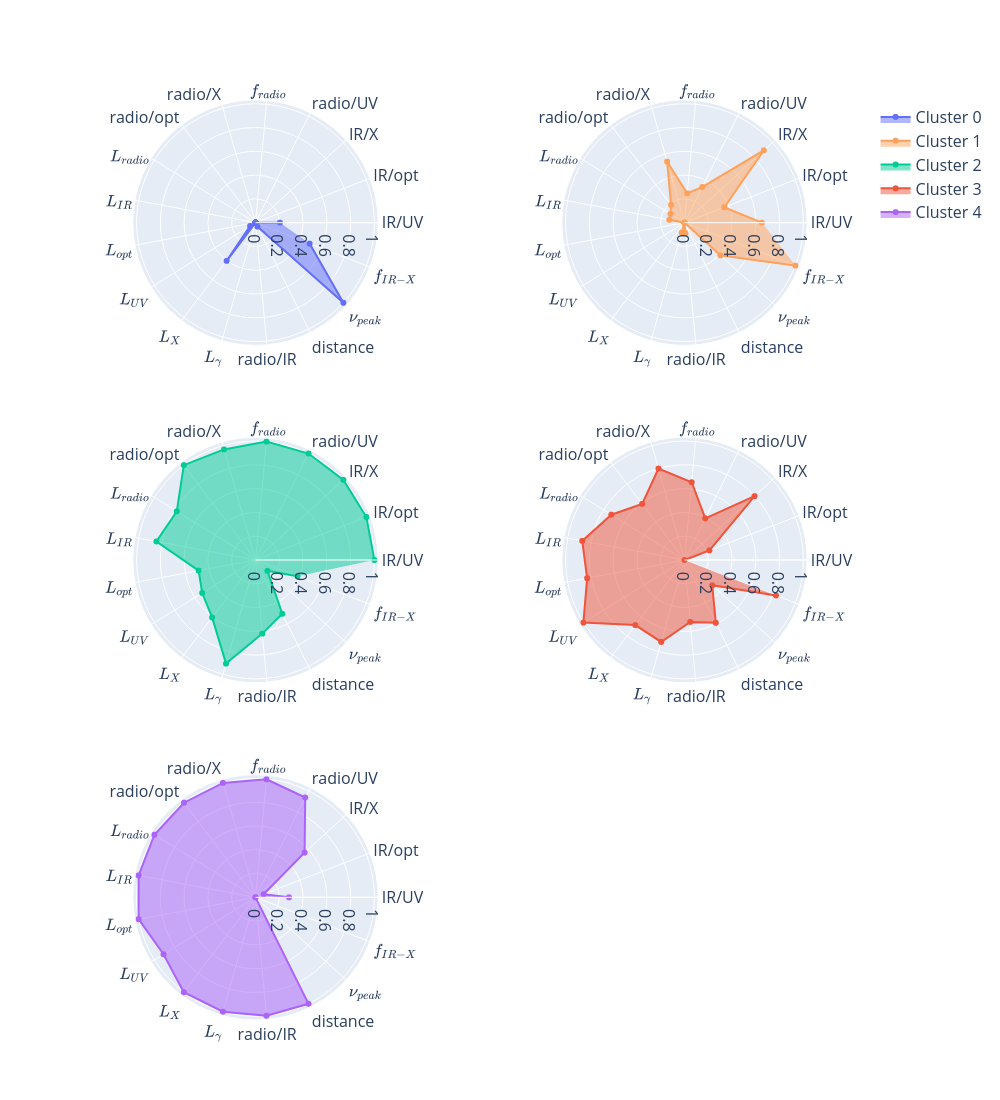

In [109]:
fig = make_subplots(rows=3, cols=2, specs=[[{'type': 'polar'}]*2]*3)

fig.update_layout(font_size=16)


fig.add_trace(go.Scatterpolar(
      name = "Cluster 0",
      r = medians_scaled.loc[0].values,
      theta = features,
      fill='toself',
      #fillcolor='#636EFA',
      line_color='#636EFA',
      #opacity=0.5,
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 1",
      r = medians_scaled.loc[1].values,
      theta = features,
      fill='toself',
      line_color='#FFA15A'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 2",
      r = medians_scaled.loc[2].values,
      theta = features,
      fill='toself',
      line_color='#00CC96'
    ), 2, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 3",
      r = medians_scaled.loc[3].values,
      theta = features,
      fill='toself',
      line_color='#EF553B'
    ), 2, 2)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 4",
      r = medians_scaled.loc[4].values,
      theta = features,
      fill='toself',
      line_color='#AB63FA'
    ), 3, 1)

#fig.add_trace(go.Scatterpolar(
#      name = "Cluster 4",
#      r = medians_scaled.loc[4].values,
#      theta = features,
#      fill='toself'
#    ), 3, 1)

fig.update_layout(
        showlegend=True, # отображение легенды
        #autosize=False, # устаналиваем свои размеры графика
        width=1000, # ширина (в пикселях)
        height=1100, # высота (в пикселях)
    )

fig.show('png')
fig.write_image('figs/polar_diag.eps')

In [68]:
cols =[
    #'Rad_opt_sp_index', 
    'alpha_1.1-2.3', 'alpha_2.3-4.8', 'alpha_4.8-7.7', 
    'alpha_7.7-11.2', 'alpha_11.2-21.7', 'comoving_distance_Mpc', 
    'tangent_wise', 'tangent_pstarrs', 'log_nu_radmax', 'log_X_luminosity_W', 
    'log_gamma_luminosity_ph', 'log_radio_luminosity', 'i_abs', 'w1_abs',
    'radio_radio', 
    'Rad_opt_sp_index',
    #'Radio_IR_hard', 
    'IR_opt', 'IR_UV', 
    'IR_X', 'var_4.8', 'i_var']
rename = {
    'Rad_opt_sp_index': 'Radio to optics', 'alpha_1.1-2.3': 'alp 1.1-2.3',
    'alpha_2.3-4.8': 'alp 2.3-4.8', 'alpha_4.8-7.7': 'alp 4.8-7.7',
    'alpha_7.7-11.2': 'alp 7.7-11.2', 'alpha_11.2-21.7': 'alp 11.2-21.7',
    'comoving_distance_Mpc': 'distance', 'tangent_wise': 'WISE tangent',
    'tangent_pstarrs': 'PanSTARRS tangent', 'log_nu_radmax': 'freq of max',
    'log_X_luminosity_W': 'X-ray lum', 'log_gamma_luminosity_ph': 'gamma lum',
    'log_radio_luminosity': 'radio_lum', 'i_abs': 'M in opt', 'w1_abs': 'M in IR',
    'radio_radio': 'Flux 1.4 to 4.8', 'Radio_IR_hard': 'Radio to IR',
    'IR_opt_hard': 'IR to optics', 'Opt_UV_hard': 'Optics to UV', 
    'IR_X_hard': 'IR to X'}

medians = final_df.groupby('cluster_kmeans')[cols].median()
medians.rename(columns=rename, inplace=True)

features = medians.columns
scaler = MinMaxScaler()
medians_scaled = pd.DataFrame(scaler.fit_transform(medians), 
                              columns=features)


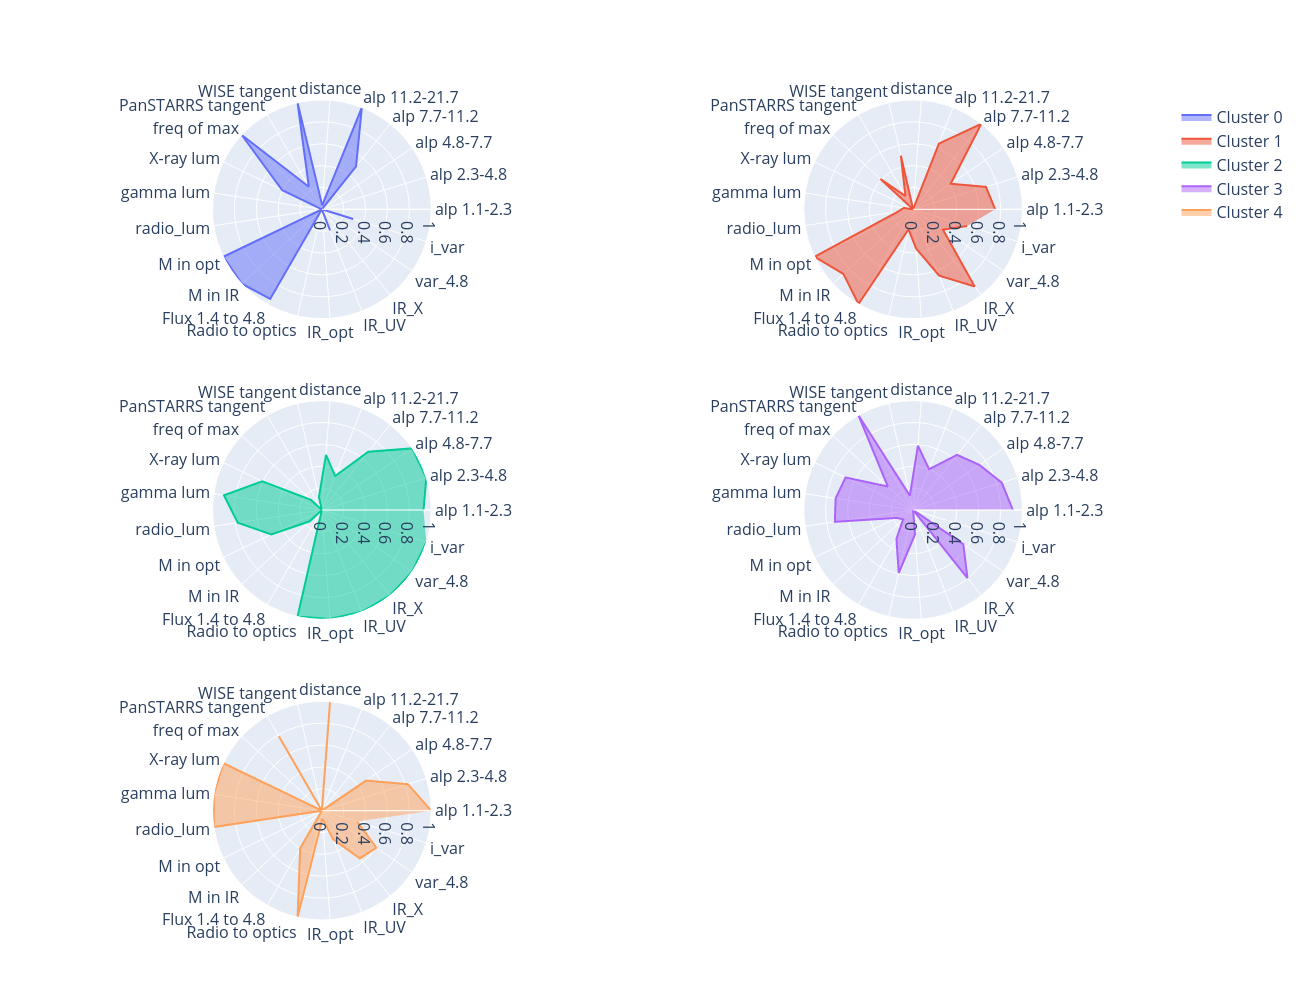

In [69]:
fig = make_subplots(rows=3, cols=2, specs=[[{'type': 'polar'}]*2]*3)

fig.update_layout(font_size=16)


fig.add_trace(go.Scatterpolar(
      name = "Cluster 0",
      r = medians_scaled.loc[0].values,
      theta = features,
      fill='toself',
    ), 1, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 1",
      r = medians_scaled.loc[1].values,
      theta = features,
      fill='toself'
    ), 1, 2)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 2",
      r = medians_scaled.loc[2].values,
      theta = features,
      fill='toself'
    ), 2, 1)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 3",
      r = medians_scaled.loc[3].values,
      theta = features,
      fill='toself'
    ), 2, 2)

fig.add_trace(go.Scatterpolar(
      name = "Cluster 4",
      r = medians_scaled.loc[4].values,
      theta = features,
      fill='toself'
    ), 3, 1)

#fig.add_trace(go.Scatterpolar(
#      name = "Cluster 4",
#      r = medians_scaled.loc[4].values,
#      theta = features,
#      fill='toself'
#    ), 3, 1)

fig.update_layout(
        showlegend=True, # отображение легенды
        autosize=False, # устаналиваем свои размеры графика
        width=1300, # ширина (в пикселях)
        height=1000, # высота (в пикселях)
    )

fig.show('png')